# GraphRAG: query test

A partire da un documento in input sono state realizzate 2 versioni di indicizzazioni:
- Usando i prompt standard della libreria GraphRAG
- applicando Prompt tuning per permettere di apprendere prompt su misura.

Entrambe le versioni sono state realizzate sia usando il modello ***Meta-Llama-3.1-8B-Instruct*** che ***Meta-Llama-3.1-70B-Instruct*** per la fase di indicizzazione.

L'obiettivo è quello di valutare se esistono differenze in base al prompt usato e valutare l'impatto di un modello più grande.

I test sono eseguiti ùutilizzando le due tipologie di ricerca nei dati indicizzati. 

Per la fase di ricerca viene sempre utilizzato il modello ***Meta-Llama-3.1-8B-Instruct***.

Per questo test non sono state utilizzate metriche di valutazione, ma il confronto consiste nel solo confronto tra i dati estratti e le risposte generate.

## 1- Prompt tuning con modello Meta-Llama-3.1-8B-Instruct

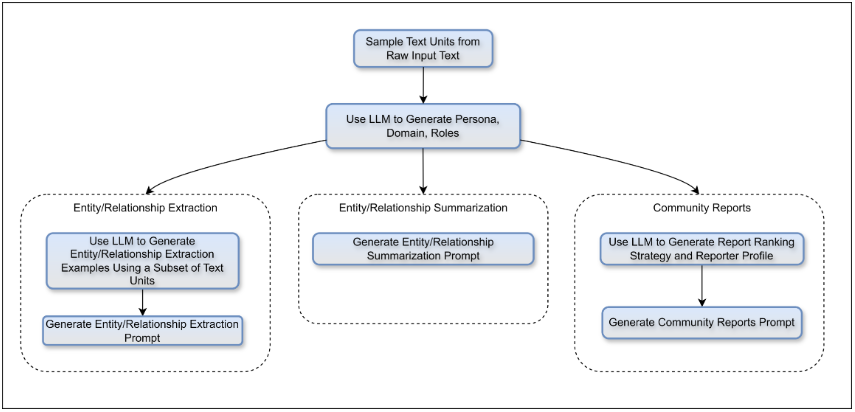

Il prompt tuning è stato effettuato con la configuarzione di default che è consigliata nel caso generale.

I parametri settabili principali sono i seguenti:
- domain: per definire il dominio dei dati.
- method: come seleziona i documenti, in generale lo fa con random ma non è detta sia la scelta migliore.
- limit: limite di chunk che deve usare.
- language: da settare se diverso dall'inglese, così LLm va a tradurre.
- max-tokens
- chunk-size
- subset-max
- no-entity-types: per estrarre entità senza tipo, da usare se le entità coprono una vasta gamma di tipologie. Potrebbe altrimenti essere utile andare a personalizzare le tipologie di entità.

### 1.1- Generazione dei prompt

Imposto le variabili d'ambiente necessarie per eseguire prompt tuning.

In [205]:
import os
print("OPENAI_API_KEY:", os.getenv("OPENAI_API_KEY"))
print("GRAPHRAG_API_KEY:", os.getenv("GRAPHRAG_API_KEY"))
print("GRAPHRAG_LLM_API_KEY:", os.getenv("GRAPHRAG_LLM_API_KEY"))

OPENAI_API_KEY: EMPTY
GRAPHRAG_API_KEY: EMPTY
GRAPHRAG_LLM_API_KEY: EMPTY


In [206]:
from dotenv import load_dotenv

load_dotenv()

True

In [207]:
print("OPENAI_API_KEY:", os.getenv("OPENAI_API_KEY"))
print("GRAPHRAG_API_KEY:", os.getenv("GRAPHRAG_API_KEY"))
print("GRAPHRAG_LLM_API_KEY:", os.getenv("GRAPHRAG_LLM_API_KEY"))

OPENAI_API_KEY: EMPTY
GRAPHRAG_API_KEY: EMPTY
GRAPHRAG_LLM_API_KEY: EMPTY


Vado a generare i prompt basati sui dati in input.

In [208]:
#!python -m graphrag.prompt_tune --root ./ragnew --config ./ragnew/settings.yaml --no-entity-types

### 1.2- Indicizzazione usando i prompt generati

In [209]:
#!python -m graphrag.index --root ./ragnew

### 1.3- Visualizzazione dei grafi generati

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from IPython.display import IFrame, display
from py2neo import Graph
from neo4j import GraphDatabase
import ast
import json
from pyvis.network import Network

In [5]:
file_path = './ragnew/output/outputPromptTuning/artifacts'

if not os.path.exists(file_path) or not os.listdir(file_path):
    print("The specified path is empty or does not exist.")
else:
    print("The path exists and is not empty.")

The path exists and is not empty.


In [212]:
def save_graphs_with_pyvis(directory):
    if not os.path.exists(directory) or not os.listdir(directory):
        print("empty path")
        return

    for filename in os.listdir(directory):
        if filename.endswith("summarized_graph.graphml"):
            file_path = os.path.join(directory, filename)
            print(f"loading: {file_path}")

            # Load graph using NetworkX
            G = nx.read_graphml(file_path)
            
            net = Network(notebook=False, cdn_resources='in_line')
            
            # add edge and nodes
            net.from_nx(G)
            
            # Save as HTML
            html_filename = "Prompt-tuning_" + os.path.splitext(filename)[0] + ".html"
            net.save_graph(html_filename)
            print(f"Graph saved as: {html_filename}")

save_graphs_with_pyvis(file_path)

loading: ./ragnew/output/outputPromptTuning/artifacts/summarized_graph.graphml
Graph saved as: Prompt-tuning_summarized_graph.html


### 1.4- Global search

In [13]:
import tiktoken
from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch

In [214]:
token_encoder = tiktoken.get_encoding("cl100k_base")

Configuro LLm usato per query.

In [215]:
api_key = os.environ["GRAPHRAG_API_KEY"]
llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

In [216]:
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

Seleziono i file utili per la fase di recupero.

In [217]:
INPUT_DIR = file_path
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

COMMUNITY_LEVEL = 2

In [218]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
print(f"Total report count: {len(report_df)}")
print(
    f"Report count after filtering by community level {COMMUNITY_LEVEL}: {len(reports)}"
)
report_df.head()

/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].fillna(-1)
/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].astype(int)


Total report count: 142
Report count after filtering by community level 3: 115


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,161,# Hogwarts Quidditch Community\n\nThe Hogwarts...,4,6.0,Hogwarts Quidditch Community,The impact severity rating is moderate due to ...,The Hogwarts Quidditch Community revolves arou...,[{'explanation': 'Oliver Wood is a key figure ...,"{\n ""title"": ""Hogwarts Quidditch Community""...",c3cde8d0-323f-438c-ba11-db9bd7665cbb
1,163,# Harry Potter Community\n\nThe community revo...,4,6.0,Harry Potter Community,The impact severity rating is moderate due to ...,The community revolves around the interactions...,[{'explanation': 'The dog is a key entity in t...,"{\n ""title"": ""Harry Potter Community"",\n ...",7d8a45bb-22ba-4776-bc4a-b7a7c8efed5f
2,142,# Hogwarts Community\n\nThe Hogwarts community...,3,6.0,Hogwarts Community,The impact severity rating is moderate due to ...,The Hogwarts community revolves around the Hog...,[{'explanation': 'Professor Flitwick is a key ...,"{\n ""title"": ""Hogwarts Community"",\n ""su...",3c5e8155-b4f0-488f-b10b-0b6863621d16
3,144,# Aunt Petunia Potter and Uncle Vernon Potter\...,3,2.0,Aunt Petunia Potter and Uncle Vernon Potter,The impact severity rating is low due to the l...,The community revolves around Aunt Petunia Pot...,[{'explanation': 'Aunt Petunia Potter is a key...,"{\n ""title"": ""Aunt Petunia Potter and Uncle...",3ba81544-400c-467d-8d9c-69f9474f58e9
4,145,# Harry Potter Community\n\nThe community revo...,3,6.0,Harry Potter Community,The impact severity rating is moderate due to ...,"The community revolves around Harry Potter, wi...",[{'explanation': 'Harry Potter has a significa...,"{\n ""title"": ""Harry Potter Community"",\n ...",13076cc9-2c4e-4d0b-8c81-eab29c5124a2


Sopra è mostrato il formato dei community reports, che verranno passati come contesto per la generazione delle risposte globali.

Definisco ora il contesto globale, basato su questi report. 

In [219]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  
    token_encoder=token_encoder,
)

I report verranno mischiati, saranno usati per intero e non solo i sommari, inoltre vengono impostati i limiti di token e altri parametri.

In [220]:
context_builder_params = {
    "use_community_summary": False,  
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 6000,  
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1500,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 1500,  
    "temperature": 0.0,
}

Viene creata una **Search** **Engine** che utilizza il modello definito, il contesto appena creato e impedisce al LLM di usare la sua conoscenza generale.

La risposta viene richiesta in formato *multiple-paragraphs* che è la modalità di default, ma si può impostare anche un formato *single-paragraph*, *prioritized-list* o *multiple-page-report*.

In [221]:
search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=6000, 
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  
    json_mode=True,  
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  
)

Vengono ora fatte domande che richiedono la comprensione generale del dataset.

In [222]:
question = "Who are the main characters in the story?"

In [223]:
result = await search_engine.asearch(question)

print(result.response)

**Main Characters in the Story**

Based on the analysis of the dataset, the main characters in the story are:

### Harry Potter

* Harry Potter is the main protagonist of the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (52, 105, 98, 95, 132, +more)].
* He is known for his bravery and involvement in the wizarding world, and is a close friend of Hermione Granger and Ron Weasley [Data: Reports (112, 43, 108, 75)].
* Harry has a difficult relationship with his Muggle relatives, the Dursleys, and is often portrayed as being brave and determined, but also struggling with the challenges of being a wizard in a Muggle world [Data: Reports (70, 92, 71, 48, 129)].

### Hermione Granger

* Hermione Granger is a main character in the story, known for her academic pursuits and involvement in magical creatures [Data: Reports (58, 43, 112, 108)].
* She is a close friend of Harry Potter and Ron Weasley, and is known for her intelligence and resourcefulnes

Posso andare ad analizzare come la risposta è stata ottenuta, visualizzando i report passati come contesto, le risposte della fase di map e i dati della fase di reduce.

In [224]:
result.context_data["reports"]

,id,title,occurrence weight,content,rank
0,58,Hermione's Community,0.0272,# Hermione's Community\n\nThe community revolv...,6.0
1,126,Dursley Family and Harry Potter,0.0256,# Dursley Family and Harry Potter\n\nThe commu...,6.0
2,43,Hogwarts Community,0.0096,# Hogwarts Community\n\nThe Hogwarts community...,6.0
3,121,King's Cross and Hogwarts,0.0064,# King's Cross and Hogwarts\n\nThe community r...,6.0
4,112,Hogwarts School of Witchcraft and Wizardry,0.0048,# Hogwarts School of Witchcraft and Wizardry\n...,6.0
...,...,...,...,...,...
110,29,Gringotts Wizarding Bank and its Associated En...,0.0176,# Gringotts Wizarding Bank and its Associated ...,6.0
111,131,The Potter Family and the Dursleys,0.0096,# The Potter Family and the Dursleys\n\nThe co...,8.0
112,2,Magical Herb Community,0.0032,# Magical Herb Community\n\nThe community revo...,4.0
113,12,Hogwarts Passage and Creature,0.0016,# Hogwarts Passage and Creature\n\nThe communi...,6.0


In [225]:
result.map_responses

[SearchResult(response=[{'answer': 'Hermione Granger is a main character in the story, known for her academic pursuits and involvement in magical creatures. She is also a close friend of Harry Potter and Ron Weasley [Data: Reports (58, 43, 112, 108)].', 'score': 90}, {'answer': 'Harry Potter is a main character in the story, known for his bravery and involvement in the wizarding world. He is also a close friend of Hermione Granger and Ron Weasley [Data: Reports (112, 43, 108, 75)].', 'score': 95}, {'answer': 'Ron Weasley is a main character in the story, known for his loyalty and involvement in the wizarding world. He is also a close friend of Harry Potter and Hermione Granger [Data: Reports (43, 112, 108)].', 'score': 85}, {'answer': 'Draco Malfoy is a main character in the story, known for his rivalry with Harry Potter and involvement in the wizarding world [Data: Reports (58, 43)].', 'score': 80}, {'answer': 'Hagrid is a main character in the story, known for his involvement in the 

In [226]:
result.reduce_context_data

"----Analyst 3----\nImportance Score: 100\nHarry Potter is the main protagonist of the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (52, 105, 98, 95, 132, +more)].\n\n----Analyst 11----\nImportance Score: 100\nHarry Potter is the main character in the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (88, 127, 138, 111, 117, 154, 74)]\n\n----Analyst 1----\nImportance Score: 95\nHarry Potter is a main character in the story, known for his bravery and involvement in the wizarding world. He is also a close friend of Hermione Granger and Ron Weasley [Data: Reports (112, 43, 108, 75)].\n\n----Analyst 1----\nImportance Score: 90\nHermione Granger is a main character in the story, known for her academic pursuits and involvement in magical creatures. She is also a close friend of Harry Potter and Ron Weasley [Data: Reports (58, 43, 112, 108)].\n\n----Analyst 2----\nImportance Score: 90\nThe main characters

Vado ad effettuare altre domande di comprensione generale.

In [385]:
question = "What are the main places where the story takes place?"

result = await search_engine.asearch(question)

print(result.response)

**Main Locations in the Story**

The story takes place in various locations, each with its own significance and importance to the plot. Based on the provided data tables, the main places where the story takes place are:

### Hogwarts School of Witchcraft and Wizardry

* **Hogwarts Castle**: The main building of the school, where students attend lessons and reside. [Data: Entities (279); Relationships (702, 846, 1200, 1404, 1281)]
* **Hogwarts Grounds**: The outdoor area surrounding the castle, where students often sneak around and engage in various activities. [Data: Entities (339); Relationships (498, 322)]
* **Dungeons**: A location within the castle where Potions lessons take place. [Data: Relationships (1548)]

### Diagon Alley and the Leaky Cauldron

* **Diagon Alley**: A hidden wizarding village located in London, where wizards and witches can purchase magical items. [Data: Entities (144); Relationships (312, 319, 638)]
* **The Leaky Cauldron**: A gathering place for wizards and 

In [228]:
question = "How does the relationship between Harry Potter and his friends (Ron and Hermione) develop throughout the book?"

result = await search_engine.asearch(question)

print(result.response)

**The Development of Harry Potter's Relationships with Ron and Hermione**

The relationships between Harry Potter and his friends Ron Weasley and Hermione Granger are a central aspect of the Harry Potter series. Throughout the books, their friendships evolve and mature, ultimately forming a strong and unbreakable bond that helps them overcome even the most daunting challenges.

**Initial Acquaintances to Deep Bonds of Trust and Loyalty**

Initially, Harry, Ron, and Hermione form a close-knit group of friends, with Harry being the central figure in their relationships. They share experiences, support each other, and work together to overcome challenges. As they navigate the challenges of Hogwarts and the wizarding world, their relationships evolve from initial acquaintances to deep bonds of trust and loyalty.

**Complex and Multifaceted Relationships**

The relationships between Harry, Ron, and Hermione are complex and multifaceted, reflecting a mix of conflict, competition, and possibl

In [229]:
question = "How do the magical and non-magical worlds intersect in the story, and how does this affect Harry's journey?"

result = await search_engine.asearch(question)

print(result.response)

**Intersection of Magical and Non-Magical Worlds**

The magical and non-magical worlds intersect in the story through various themes, events, and characters. The intersection of these worlds creates a sense of tension, conflict, and opportunities for growth and learning for Harry.

**Key Points of Intersection**

*   **Platform Nine and Three Quarters**: The magical and non-magical worlds intersect at King's Cross station, where Platform Nine and Three Quarters serves as a portal between the two worlds [Data: Reports (121, 112, 446)].
*   **Diagon Alley**: The intersection is also evident in Diagon Alley, a hidden wizarding street in London [Data: Reports (114, 149, 64, 65, 40)].
*   **Magical Creatures and Events**: The presence of magical creatures and events in the non-magical world, such as the troll in the Hogwarts community [Data: Reports (105, 98, 95)], creates a sense of tension and conflict between the two worlds.
*   **Muggle-Born Wizards and Witches**: The intersection is al

### 1.5- Local search

In [14]:
from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

Seleziono i file utili per la ricerca locale.

In [15]:
INPUT_DIR = file_path
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 3

Conto il numero di entità, relazioni, report e unità di testo.

In [16]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head(10)

Entity count: 4980


,level,title,type,description,source_id,community,degree,human_readable_id,id,size,graph_embedding,entity_type,top_level_node_id,x,y
0,0,MR. DURSLEY,PERSON,"Based on the provided data, here is a comprehe...","03750bf7ca5ceca4b328faa4cdf4911a,04f50415dd00b...",5,33,0,b45241d70f0e43fca764df95b2b81f77,33,None,None,b45241d70f0e43fca764df95b2b81f77,0,0
1,0,MRS. DURSLEY,PERSON,"Mrs. Dursley is Harry Potter's aunt, who is ma...","3d1c0b286ee7c33054ec655db1d6a661,3d45e45e678d3...",5,15,1,4119fd06010c494caa07f439b333f4c5,15,None,None,4119fd06010c494caa07f439b333f4c5,0,0
2,0,DUDLEY DURSLEY,PERSON,Dudley Dursley is Harry Potter's Muggle cousin...,"059ae95b48061f10670efdf2ed9ed54d,08ba1a94b6b20...",5,42,2,d3835bf3dda84ead99deadbeac5d0d7d,42,None,None,d3835bf3dda84ead99deadbeac5d0d7d,0,0
3,0,GRUNNINGS,ORGANIZATION,"Grunnings is a firm that makes drills, and is ...",5dc91481d05b9302624cb898d7ba64ed,5,1,3,077d2820ae1845bcbb1803379a3d1eae,1,None,None,077d2820ae1845bcbb1803379a3d1eae,0,0
4,0,PRIVET DRIVE,LOCATION,"Based on the provided data, the comprehensive ...","00ff980664b68cfb1856a1486883cefe,099665247bc2b...",5,8,4,3671ea0dd4e84c1a9b02c5ab2c8f4bac,8,None,None,3671ea0dd4e84c1a9b02c5ab2c8f4bac,0,0
5,0,NUMBER FOUR PRIVET DRIVE,LOCATION,"Based on the provided data, the comprehensive ...","5dc91481d05b9302624cb898d7ba64ed,82ebf7fc9fd7c...",5,4,5,19a7f254a5d64566ab5cc15472df02de,4,None,None,19a7f254a5d64566ab5cc15472df02de,0,0
6,0,MRS. POTTER,PERSON,Mrs. Potter is the sister of Mrs. Dursley and ...,cdba655d39b0874c1ee8ec0edb2c2a39,5,1,6,e7ffaee9d31d4d3c96e04f911d0a8f9e,1,None,None,e7ffaee9d31d4d3c96e04f911d0a8f9e,0,0
7,0,MR. POTTER,PERSON,"Based on the provided data, the comprehensive ...","245eab670313853da77688ae3022dfde,cdba655d39b08...",5,2,7,f7e11b0e297a44a896dc67928368f600,2,None,None,f7e11b0e297a44a896dc67928368f600,0,0
8,0,THE DURSLEYS,FAMILY,The Dursleys are a Muggle family consisting of...,"2798f7f9b1d81a62b64e2109ebd7e074,35c2e2606f9bb...",5,11,8,1fd3fa8bb5a2408790042ab9573779ee,11,None,None,1fd3fa8bb5a2408790042ab9573779ee,0,0
9,0,THE POTTERS,FAMILY,"Based on the provided data, the comprehensive ...","8f98378b2011a145c9695fe71cabbfd4,9e7cd65da8929...",5,10,9,27f9fbe6ad8c4a8b9acee0d3596ed57c,10,None,None,27f9fbe6ad8c4a8b9acee0d3596ed57c,0,0


In [17]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head(10)

Relationship count: 2122


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,MR. DURSLEY,GRUNNINGS,1.0,Mr. Dursley is the director of Grunnings,[5dc91481d05b9302624cb898d7ba64ed],0057fb2ddc0e4088ae5099b7ffa137da,0,33,1,34
1,MR. DURSLEY,DUDLEY DURSLEY,2.0,"Based on the provided data, here is a comprehe...","[5dc91481d05b9302624cb898d7ba64ed, 8194de9b4d7...",d67d67cc3698438db76eb4a7f75e1ea0,1,33,42,75
2,MR. DURSLEY,NUMBER FOUR PRIVET DRIVE,1.0,Mr. Dursley lives at number four Privet Drive,[5dc91481d05b9302624cb898d7ba64ed],c23761290af24cf29adc1ee8644bdad0,2,33,4,37
3,MR. DURSLEY,THE POTTERS,3.0,"Based on the provided data, here is a comprehe...","[8f98378b2011a145c9695fe71cabbfd4, 9e7cd65da89...",de51b828ce1f442bbb19a7b20bce9dda,3,33,10,43
4,MR. DURSLEY,CAT,3.0,"Based on the provided data, here is a comprehe...","[3d45e45e678d3331b358687f6984e582, 70118e7c8f1...",4a3ff6a3471945fd8c7fd5c171c56d56,4,33,12,45
5,MR. DURSLEY,PRIVET DRIVE,1.0,"Mr. Dursley lives on Privet Drive, where he se...",[a6408a25abf6ca344226c5f1b56bd8df],31bb84eb2a834dabacc0ed51af4fcefd,5,33,8,41
6,MR. DURSLEY,MAP,1.0,"Mr. Dursley sees a cat reading a map, but late...",[a6408a25abf6ca344226c5f1b56bd8df],5070012e83e7442381bcba1cdacdb7d8,6,33,2,35
7,MR. DURSLEY,SIGN,1.0,"Mr. Dursley sees a cat looking at a sign, whic...",[a6408a25abf6ca344226c5f1b56bd8df],5eda9074df124f5497f17b61badd52ac,7,33,2,35
8,MR. DURSLEY,TOWN,1.0,Mr. Dursley is driving to town,[70118e7c8f155ad38066b8b27a73051e],4cf4107b0e2842778aaa658a1a85f3b3,8,33,1,34
9,MR. DURSLEY,DRILLS,1.0,Mr. Dursley is hoping to get drills,[70118e7c8f155ad38066b8b27a73051e],7f4857f94b4e4e49be7236a42071e167,9,33,1,34


In [18]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
print(f"Report records: {len(report_df)}")

Report records: 142


/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].fillna(-1)
/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].astype(int)


In [19]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 734


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,5dc91481d05b9302624cb898d7ba64ed,Harry Potter and the Sorcerer's Stone\nCHAPTE...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[0057fb2ddc0e4088ae5099b7ffa137da, d67d67cc369..."
1,cdba655d39b0874c1ee8ec0edb2c2a39,in very useful as she\nspent so much of her t...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[4119fd06010c494caa07f439b333f4c5, d3835bf3dda...","[cd7f555e4ab948ba94bade14e262ff84, 86cd53087b2..."
2,bfecca209a4227cae47d185191edd0a3,ish as it was\npossible to be. The Dursleys sh...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[de51b828ce1f442bbb19a7b20bce9dda, 5dc3480806b..."
3,a6408a25abf6ca344226c5f1b56bd8df,street that he noticed the first sign of\nsom...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 3671ea0dd4e...","[4a3ff6a3471945fd8c7fd5c171c56d56, 31bb84eb2a8..."
4,70118e7c8f155ad38066b8b27a73051e,at the sign; cats\ncouldn't read maps or sign...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 254770028d7...","[4a3ff6a3471945fd8c7fd5c171c56d56, 4cf4107b0e2..."


Definisco il modello che utilizzo per le query.

In [20]:
from dotenv import load_dotenv

load_dotenv()

True

In [21]:
api_key = os.environ["GRAPHRAG_API_KEY"]

llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

Definisco l'embedder usato nella ricerca locale.

In [22]:
embedding_model = "nomic-embed-text"  
api_base = "http://localhost:11434/api/embeddings"

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=api_base,  
    api_type=OpenaiApiType.OpenAI,  
    model=embedding_model,
    deployment_name=embedding_model,  
    max_retries=20
)

Come per la ricerca globale si definisce un contesto. 

In questo caso non vengono usati solo i report, ma anche entitàm relazioni e chunk di testo.

In [23]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates=None, # i have not set covariates during indexing
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

Definisco i parametri della ricerca locale: le porzioni di context window assegnate ai chunks, reports, entità e relazioni, le impostazioni della memoria conversazionale, il numero massimo di token, di entità e relazioni restituibili e altre opzioni.

In [239]:
local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  
    "max_tokens": 6000,  
}

llm_params = {
    "max_tokens": 1000, 
    "temperature": 0.0,
}

Creo una **Search** **Engine** con gli stessi parametri della ricerca globale.

In [240]:
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  
)

Provo ad effettuare delle domande specifiche.

In [241]:
question = "What is the name of the place where the protagonist went shopping? What shops did he visit and what did he buy?"

result = await search_engine.asearch(question)
print(result.response)

**Shopping in Diagon Alley**

The protagonist, Harry Potter, went shopping in Diagon Alley, a hidden street in London that is home to a variety of magical shops and businesses.

**Shops Visited**
----------------

According to the text, Harry visited the following shops in Diagon Alley:

*   **Ollivander's Wand Shop** [Data: Entities (441); Relationships (1436)]
*   **Madam Malkin's Robe Shop** [Data: Entities (359); Relationships (379)]
*   **Flourish and Blotts** [Data: Entities (403)]
*   **Eeylops Owl Emporium** [Data: Entities (356); Relationships (1360)]
*   **Gringotts Wizarding Bank** [Data: Sources (142)]
*   **Cauldron Shop** [Data: Sources (118)]

**Items Purchased**
------------------

Harry purchased the following items during his shopping trip:

*   A wand from Ollivander's Wand Shop [Data: Sources (173)]
*   A set of Hogwarts robes from Madam Malkin's Robe Shop [Data: Sources (154)]
*   Books from Flourish and Blotts [Data: Sources (143)]
*   An owl from Eeylops Owl Empo

Posso visualizzare entità, relazioni, report e chunks utilizzati per la risposta. 

Con i seguenti dati si può valutare il procedimento di recupero e si potrebbero creare delle visualizzazioni.

In [242]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,441,OLLIVANDER'S SHOP,Ollivander's shop is a place where wands are m...,2,True
1,359,SHOP,"Based on the provided data, the comprehensive ...",4,True
2,390,BOOKSHOP,The bookshop is a location where the boy's fat...,1,True
3,288,DIAGON ALLEY,"Based on the provided data, the comprehensive ...",6,True
4,339,BOOK SHOP,There is a big book shop on one side of the st...,0,True
5,403,FLORISH AND BLOTT,Flourish and Blotts is a shop where Harry buys...,1,True
6,36,THE BAKERY,The bakery is a place where Mr. Dursley buys b...,1,True
7,77,STREET,"Based on the provided data, here is a comprehe...",2,True
8,425,OLIVANDERS SHOP,Ollivanders shop is a narrow and shabby place ...,0,True
9,504,DROOBLE'S BEST,Drooble's Best is a shop that sells a variety ...,1,True


In [243]:
result.context_data["relationships"]

,id,source,target,description,weight,rank,links,in_context
0,379,HARRY POTTER,SHOP,Harry Potter is being fitted for his Hogwarts ...,1.0,467,2,True
1,415,HARRY POTTER,OLLIVANDER'S SHOP,Harry Potter is at Ollivander's shop trying to...,1.0,465,2,True
2,168,HARRY,SHOP,Harry and the shops are in the same street,1.0,105,1,True
3,1374,BOY,BOOKSHOP,The boy's father is buying books in the bookshop,1.0,13,1,True
4,1359,APOTHECARY,SHOP,The Apothecary and the shops are in the same s...,1.0,9,1,True
5,1360,EEYLOPS OWL EMPORIUM,SHOP,Eeylops Owl Emporium and the shops are in the ...,1.0,8,1,True
6,1436,MR. OLLIVANDER,OLLIVANDER'S SHOP,Mr. Ollivander works at Ollivander's shop,1.0,7,1,True


In [244]:
result.context_data["sources"]

,id,text
0,173,", but Mr.\nOllivander snatched it out of his h..."
1,143,"gotta get yer money\nfirst.""\nHarry wished he..."
2,154,"Harry entered Madam\nMalkin's shop alone, fee..."
3,167,instead at the thousands of narrow\nboxes pil...
4,176,. Yew. Curious indeed how these things\nhappen...
5,144,"with\nbroomsticks in it. ""Look,"" Harry heard ..."
6,142,second later they\nwere facing an archway lar...
7,118,\ntell yeh the truth. In me third year. They s...
8,201,"where You-Know-Who\n""Yes,"" said Harry, ""but I..."
9,188,not to panic.\nAccording to the large clock o...


Faccio altre domande specifiche.

In [245]:
question = "What is protagonist's reaction when he finds out that he is a wizard?"

result = await search_engine.asearch(question)
print(result.response)

**Protagonist's Reaction to Discovering his Wizarding Heritage**

When Harry Potter, the protagonist, discovers that he is a wizard, he is initially shocked and disbelieving. This reaction is evident in the following text:

"Ten years, ten miserable years, as long as he could remember, ever since he'd been a baby and his parents had died in that car crash. He couldn't remember being in the car when his parents had died. Sometimes, when he strained his memory during long hours in his cupboard, he came up with a strange vision: a blinding flash of green light and a burning pain on his forehead. This, he supposed, was the crash, though he couldn't imagine where all the green light came from. He couldn't remember his parents at all. His aunt and uncle never spoke about them, and of course he was forbidden to ask questions." [Data: Sources (48)]

Harry's lack of knowledge about his parents and his own heritage creates a sense of mystery and confusion, which is further exacerbated by his dis

In [246]:
question = "How does Aunt Petunia describe Harry's parents when she gets angry at him?"

result = await search_engine.asearch(question)
print(result.response)

**Aunt Petunia's Description of Harry's Parents**

When Aunt Petunia gets angry at Harry, she describes his parents in a negative light. According to the data, Aunt Petunia says:

"...my dratted sister being what she was? Oh, she got a letter just like that and disappeared off to that-that school-and came home every vacation with her pockets full of frog spawn, turning teacups into rats." [Data: Sources (40)]

In this quote, Aunt Petunia portrays Harry's mother as a "freak" who was involved in strange and magical activities. She also implies that Harry's mother was somehow abnormal or unacceptable.

Aunt Petunia continues to describe Harry's parents by saying:

"...they met that Potter at school and they left and got married and had you, and of course I knew you'd be just the same..." [Data: Sources (40)]

Here, Aunt Petunia suggests that Harry's father, Mr. Potter, was somehow responsible for Harry's supposed "freakishness" and that Harry would grow up to be just like his parents.

It

In [247]:
question = "During the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. Which two houses does the Hat consider, and what makes it choose Gryffindor in the end?"
result = await search_engine.asearch(question)
print(result.response)

**Sorting Ceremony: Harry's Sorting Decision**

During the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. The Hat considers two houses before finally choosing Gryffindor.

**Houses Considered**
--------------------

The Sorting Hat initially considers **Gryffindor** and **Slytherin** as potential houses for Harry. This is evident from the text:

* "Hmm," said a small voice in his ear. "Difficult. Very difficult. Plenty of courage, I see. Not a bad mind either. There's talent, A my goodness, yes -- and a nice thirst to prove yourself, now that's interesting.... So where shall I put you?" [Data: Sources (96)]
* "Not Slytherin, not Slytherin," Harry thought wildly, trying to influence the Hat's decision. [Data: Sources (242)]

**Reasons for Choosing Gryffindor**
---------------------------------

The Sorting Hat ultimately chooses Gryffindor for Harry due to his **courage** and **thirst to prove himself**. The Hat sings:

* "You might belong in Gryffin

In [248]:
question = "Which ingredients are needed for Professor Snape's potions class?"

result = await search_engine.asearch(question)
print(result.response)

**Ingredients for Professor Snape's Potions Class**

Based on the provided data, we can identify some of the ingredients needed for Professor Snape's potions class.

**Unicorn Horn and Tail Hair**
According to the description of the entity "POTIONS" [Data: Entities (704)], unicorn horn and tail hair are used in potions. This is also mentioned in the relationship between Harry Potter and Potions [Data: Relationships (652)].

**Dried Nettles and Snake Fangs**
In the source text [Data: Sources (293)], it is mentioned that Snape has the students weigh dried nettles and crush snake fangs during a potions lesson.

**Asphodel and Wormwood**
Professor Snape mentions that asphodel and wormwood make a sleeping potion so powerful it is known as the Draught of Living Death [Data: Sources (292)].

**Monkshood and Wolfsbane**
Snape also mentions that monkshood and wolfsbane are the same plant, which also goes by the name of aconite [Data: Sources (292)].

**Bezoar**
A bezoar is a stone taken from th

### 1.6- Question generation

Provo il modulo di generazione di domande di follow-up. Per fare ciò devo avere delle domande correlate tra loro, quindi farò una serie di query locali correlate e le passerò al generatore di query.

In [249]:
question = "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"

result = await search_engine.asearch(question)
print(result.response)

**Discovery of the Philosopher's Stone's Location**

Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts through a combination of research and conversations with other characters.

**Research and Conversations**

The trio begins their research in the Hogwarts library, where they come across a book about Nicolas Flamel, the only known maker of the Philosopher's Stone. They learn that Flamel has been alive for over 600 years due to the Stone's powers and that he is hiding in the Hogwarts grounds. [Data: Sources (469, 175, 490); Entities (968, 924)]

**Conversation with Hagrid**

Harry, Ron, and Hermione also have a conversation with Hagrid, the gamekeeper, who is hiding something behind his back. They ask him about the Philosopher's Stone, and although he doesn't directly answer their question, he seems to be aware of their knowledge and warns them not to speak about it in public. [Data: Sources (490, 183, 493); Entities (817, 915)]

**Conversation

In [250]:
question = "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**Magical Protections Encountered by Harry, Ron, and Hermione**

As Harry, Ron, and Hermione attempt to reach the Philosopher's Stone, they face various magical protections that hinder their progress. These obstacles are designed to prevent unauthorized access to the Stone, which is a powerful magical object with the ability to grant eternal life and transform any metal into gold.

**The Three-Headed Dog, Fluffy**

One of the primary magical protections encountered by the trio is the three-headed dog, Fluffy. This ferocious creature is guarding the Philosopher's Stone and poses a significant threat to anyone who tries to pass it. According to Hagrid, Fluffy is a powerful magical creature that is being used to protect the Stone [Data: Sources (469, 490, 494); Relationships (184)].

**The Sorcerer's Stone's Protective Charms**

In addition to Fluffy, the Philosopher's Stone itself has various protective charms that prevent unauthorized access. These charms are designed to detect and dete

In [251]:
question = "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**The Three Friends' Contributions to Overcoming the Challenges**

The trio of Harry Potter, Ron Weasley, and Hermione Granger face numerous obstacles as they attempt to retrieve the Philosopher's Stone. Each of their unique skills and strengths plays a crucial role in overcoming these challenges.

**Harry's Contributions**

Harry's bravery and willingness to take risks are essential in their quest. He is the first to volunteer to face the challenges ahead, often putting himself in harm's way to protect his friends. Harry's determination and courage inspire Ron and Hermione to follow him, even when the situation seems impossible.

Harry's contributions are supported by multiple data references [Data: Relationships (684, 1656, 1848); Sources (618, 635, 638)].

**Ron's Contributions**

Ron's loyalty and quick thinking are vital in their mission. He often comes up with creative solutions to the problems they face, such as his idea to use the chess game to distract Snape. Ron's bravery is 

In [252]:
question = "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"

result = await search_engine.asearch(question)
print(result.response)

**The Final Attempt to Steal the Philosopher's Stone**

According to the provided data, the final person trying to steal the Philosopher's Stone is revealed to be Professor Quirrell, a Hogwarts staff member who teaches Defense Against the Dark Arts [Data: Entities (349); Sources (635)].

**Quirrell's True Intentions**

Quirrell's possession by Lord Voldemort is a crucial aspect of his attempt to steal the Stone. As revealed in the data, Quirrell's behavior becomes increasingly erratic and suspicious, ultimately leading to his downfall [Data: Entities (349); Sources (628)].

**Harry's Role in Foiling the Attempt**

Harry Potter plays a crucial role in foiling Quirrell's attempt to steal the Stone. By using the Mirror of Erised, Harry is able to retrieve the Stone from Quirrell's pocket [Data: Entities (972); Sources (627)].

**The Final Confrontation**

In the final confrontation, Harry is able to outsmart Quirrell and ultimately leads to his downfall. The data suggests that Quirrell's 

In [253]:
question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [254]:
question_history = [
    "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"
    "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?",
    "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?",
    "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)

["- What is the role of the Philosopher's Stone in the story, and how do Harry, Ron, and Hermione work together to prevent it from being stolen?", "- How do the magical protections and obstacles that guard the Philosopher's Stone contribute to the challenges that Harry, Ron, and Hermione face in their quest to retrieve it?", "- What is the significance of the Philosopher's Stone's power and the characters' interactions with it, and how does it drive the plot forward in the story?", "- How do the relationships between Harry, Ron, Hermione, and other characters, such as Quirrell and Snape, impact their efforts to prevent the Philosopher's Stone from being stolen?", "- What is the ultimate goal of the person trying to steal the Philosopher's Stone, and how does Harry's determination and bravery ultimately lead to their downfall?"]


## 2- Prompt di default con modello Meta-Llama-3.1-8B-Instruct

Viene effettuata ora l'indicizzazione e le successive fasi di ricerca, tramite l'utilizzo di prompt di default.

La documentazione ufficiale riporta che i prompt generici dovrebbero funzionare bene in contesti standard e potrebbe non essere necessario il prompt tuning. 
Verrano seguiti gli step del precedente test.

### 2.1- Indicizzazione con i prompt standard

In [255]:
#!python -m graphrag.index --root ./ragstandard

### 2.2- Visualizzazione dei grafi generati

In [256]:
file_path = './ragstandard/output/20240902-204855/artifacts'

if not os.path.exists(file_path) or not os.listdir(file_path):
    print("The specified path is empty or does not exist.")
else:
    print("The path exists and is not empty.")

The path exists and is not empty.


In [257]:
def save_graphs_with_pyvis(directory):
    if not os.path.exists(directory) or not os.listdir(directory):
        print("empty path")
        return

    for filename in os.listdir(directory):
        if filename.endswith("summarized_graph.graphml"):
            file_path = os.path.join(directory, filename)
            print(f"loading: {file_path}")

            # Load graph using NetworkX
            G = nx.read_graphml(file_path)
            
            net = Network(notebook=False, cdn_resources='in_line')
            
            # add edge and nodes
            net.from_nx(G)
            
            # Save as HTML
            html_filename = "Standard-prompt_" + os.path.splitext(filename)[0] + ".html"
            net.save_graph(html_filename)
            print(f"Graph saved as: {html_filename}")

save_graphs_with_pyvis(file_path)

loading: ./ragstandard/output/20240902-204855/artifacts/summarized_graph.graphml
Graph saved as: Standard-prompt_summarized_graph.html


### 2.3- Global search

In [258]:
token_encoder = tiktoken.get_encoding("cl100k_base")

In [259]:
api_key = os.environ["GRAPHRAG_API_KEY"]
llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

In [260]:
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

In [261]:
INPUT_DIR = file_path
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

COMMUNITY_LEVEL = 3

In [262]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
print(f"Total report count: {len(report_df)}")
print(
    f"Report count after filtering by community level {COMMUNITY_LEVEL}: {len(reports)}"
)
report_df.head()

Total report count: 66
Report count after filtering by community level 3: 54


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,67,# Harry's Family and the Dursleys\n\nThe commu...,3,6.0,Harry's Family and the Dursleys,The impact severity rating is moderate due to ...,The community revolves around Harry's family a...,[{'explanation': 'Harry is the central figure ...,"{\n ""title"": ""Harry's Family and the Dursle...",efae1f7b-9602-4c00-a00a-00a944999f2c
1,68,# Uncle Vernon's Household\n\nThe community re...,3,6.0,Uncle Vernon's Household,The impact severity rating is moderate due to ...,The community revolves around Uncle Vernon's h...,[{'explanation': 'Uncle Vernon is the central ...,"{\n ""title"": ""Uncle Vernon's Household"",\n ...",06d1ea26-95d7-411d-b59e-74844c394bed
2,69,# Mrs. Weasley and The End\n\nThe community re...,3,2.0,Mrs. Weasley and The End,The impact severity rating is low due to the l...,The community revolves around Mrs. Weasley and...,[{'explanation': 'Mrs. Weasley is a character ...,"{\n ""title"": ""Mrs. Weasley and The End"",\n ...",ddc812c9-f351-42de-8de4-2c4790c8dc82
3,44,# Bill Weasley and Gringotts\n\nThe community ...,2,2.0,Bill Weasley and Gringotts,The impact severity rating is low due to the r...,"The community revolves around Bill Weasley, wh...",[{'explanation': 'Bill Weasley is a key entity...,"{\n ""title"": ""Bill Weasley and Gringotts"",\...",40155566-82cb-46ab-98e5-c8be2f2c7d2b
4,45,# Hogwarts Community\n\nThe Hogwarts community...,2,6.0,Hogwarts Community,The impact severity rating is moderate due to ...,The Hogwarts community revolves around the sch...,[{'explanation': 'Harry Potter is a central fi...,"{\n ""title"": ""Hogwarts Community"",\n ""su...",ed142f26-704f-4f0f-86a1-7108c068de6f


In questo caso sono stati creati meno report di comunità rispetto a prima.

In [263]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  
    token_encoder=token_encoder,
)

In [264]:
context_builder_params = {
    "use_community_summary": False,  
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 6000,  
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1500,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 1500,  
    "temperature": 0.0,
}

In [265]:
search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=6000, 
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  
    json_mode=True,  
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  
)

Pongo ora le stesse domande del test precedente.

In [266]:
question = "Who are the main characters in the story?"

In [267]:
result = await search_engine.asearch(question)

print(result.response)

**Main Characters in the Story**

Based on the analysis of the dataset, the main characters in the story can be identified as follows:

### Harry Potter

* Harry Potter is the central figure in the story, being a student at Hogwarts School of Witchcraft and Wizardry and a key player in the fight against Voldemort [Data: Reports (48, 61, 27, 49, 11, +more)].
* He is the son of James and Lily Potter and has a close relationship with his friends Ron Weasley and Hermione Granger [Data: Reports (48, 61, 27, 49, 11)].
* Harry is also known for his scar, which is a result of a curse from Voldemort [Data: Reports (10)].

### Voldemort

* Voldemort is the main antagonist of the story, being a dark wizard who killed the Potters and is the central figure in the Voldemort's Threat Network community [Data: Reports (48, 27, 49)].
* He is a complex character with a mysterious past and a significant influence in the community [Data: Reports (15, 17, 19)].

### Ron Weasley

* Ron Weasley is a close fri

In [268]:
result.context_data["reports"]

,id,title,occurrence weight,content,rank
0,64,Dumbledore's Community,0.297872,# Dumbledore's Community\n\nThe community revo...,8.0
1,48,Voldemort's Threat Network,0.255319,# Voldemort's Threat Network\n\nThe community ...,8.0
2,27,Hogwarts Community,0.212766,# Hogwarts Community\n\nThe Hogwarts community...,6.0
3,49,Godric's Hollow Community,0.042553,# Godric's Hollow Community\n\nThe community r...,8.0
4,61,Hogwarts Community,0.042553,# Hogwarts Community\n\nThe community revolves...,6.0
5,5,Quidditch Community,0.021277,# Quidditch Community\n\nThe Quidditch communi...,6.0
6,11,Seven Individuals and Their Relationships,0.021277,# Seven Individuals and Their Relationships\n\...,3.0
7,60,Hogwarts School of Witchcraft and Wizardry Com...,0.340426,# Hogwarts School of Witchcraft and Wizardry C...,6.0
8,59,Hogwarts Community,0.276596,# Hogwarts Community\n\nThe Hogwarts community...,7.0
9,29,Harry's World,0.127660,# Harry's World\n\nThe community revolves arou...,3.0


In [269]:
result.map_responses

[SearchResult(response=[{'answer': 'Harry Potter is the main protagonist of the story, being the son of James and Lily Potter and a close friend of George Weasley and Fred Weasley [Data: Reports (48, 61, 27, 49, 11)]', 'score': 90}, {'answer': 'Albus Dumbledore is a key figure in the story, being the headmaster of Hogwarts School of Witchcraft and Wizardry and a close friend of James and Lily Potter [Data: Reports (64, 49, 61, 27)]', 'score': 85}, {'answer': "Voldemort is the main antagonist of the story, being a dark wizard who killed the Potters and is the central figure in the Voldemort's Threat Network community [Data: Reports (48, 27, 49)]", 'score': 95}, {'answer': 'Professor McGonagall is a key character in the story, being a close friend of James and Lily Potter and a respected figure at Hogwarts [Data: Reports (48, 49, 61, 27)]', 'score': 80}, {'answer': 'George Weasley and Fred Weasley are key characters in the story, being friends of Harry Potter and members of Hufflepuff ho

In [270]:
result.reduce_context_data

"----Analyst 1----\nImportance Score: 95\nVoldemort is the main antagonist of the story, being a dark wizard who killed the Potters and is the central figure in the Voldemort's Threat Network community [Data: Reports (48, 27, 49)]\n\n----Analyst 1----\nImportance Score: 90\nHarry Potter is the main protagonist of the story, being the son of James and Lily Potter and a close friend of George Weasley and Fred Weasley [Data: Reports (48, 61, 27, 49, 11)]\n\n----Analyst 2----\nImportance Score: 90\nHarry Potter is the central figure in the story, being a student at Hogwarts School of Witchcraft and Wizardry and a key player in the story [Data: Reports (59, 29, 22, 24, 53, +more)].\n\n----Analyst 3----\nImportance Score: 90\nHarry Potter is a central figure in the story, being a part of the wizarding world and having relationships with other key entities such as Ron and Hermione [Data: Reports (21, 40, 34, 58, 28)].\n\n----Analyst 4----\nImportance Score: 90\nHarry Potter is a central figur

Continuo con le domande del test precedente.

In [386]:
question = "What are the main places where the story takes place?"

result = await search_engine.asearch(question)

print(result.response)

**Main Locations in the Story**

The story takes place in various locations, each with its own significance and importance to the plot. Based on the provided data tables, the main places where the story takes place are:

### Hogwarts School of Witchcraft and Wizardry

* **Hogwarts Castle**: The main building of the school, where students attend lessons and reside. [Data: Entities (279); Relationships (702, 846, 1200, 1404, 1281)]
* **Hogwarts Grounds**: The outdoor area surrounding the castle, where students often sneak around and engage in various activities. [Data: Entities (339); Relationships (498, 322)]
* **Dungeons**: A location within the castle where Potions lessons take place. [Data: Relationships (1548)]

### Diagon Alley and the Leaky Cauldron

* **Diagon Alley**: A hidden wizarding village located in London, where wizards and witches can purchase magical items. [Data: Entities (144); Relationships (312, 319, 638)]
* **The Leaky Cauldron**: A gathering place for wizards and 

In [272]:
question = "How does the relationship between Harry Potter and his friends (Ron and Hermione) develop throughout the book?"

result = await search_engine.asearch(question)

print(result.response)

**The Development of Harry Potter's Relationship with Ron and Hermione**

The relationship between Harry Potter and his friends Ron Weasley and Hermione Granger is a central theme throughout the book. As they navigate the challenges of Hogwarts School of Witchcraft and Wizardry, their bond and loyalty to each other serve as a source of strength and inspiration.

**Initial Friendship and Trust**

Initially, Harry, Ron, and Hermione form a close friendship, with Ron and Hermione being introduced as Harry's best friends. They work together to overcome obstacles and achieve their goals, demonstrating the power of teamwork and friendship. Their relationships are built on trust, loyalty, and a deep understanding of each other's strengths and weaknesses.

**Challenges and Conflicts**

As the series progresses, Ron and Hermione's relationships with Harry become increasingly complex. Ron struggles with feelings of jealousy and insecurity, while Hermione's perfectionism and competitiveness somet

In [273]:
question = "How do the magical and non-magical worlds intersect in the story, and how does this affect Harry's journey?"

result = await search_engine.asearch(question)

print(result.response)

**Intersection of Magical and Non-Magical Worlds**

The intersection of the magical and non-magical worlds is a central theme in the story, highlighting the complexities and challenges that Harry faces as a wizard in a non-magical world. This intersection is evident in various aspects of the story, including the presence of magical creatures and events in the non-magical world, the interactions between magical and non-magical characters, and the impact of the wizarding world on the non-magical world.

**Magical Creatures and Events in the Non-Magical World**

The story features several instances of magical creatures and events appearing in the non-magical world, such as the Dementors in Little Hangleton, the Hogwarts Express in the Muggle world, and the boa constrictor's escape from the zoo. These events create tension and conflict between the two worlds, affecting Harry's journey as he navigates his dual identity as a wizard and a Muggle.

**Interactions between Magical and Non-Magica

### 2.4- Local search

In [274]:
INPUT_DIR = file_path
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 3

Conteggio del numero di entità, relazioni, report e chunk.

In [275]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head(10)

Entity count: 1388


,level,title,type,description,source_id,community,degree,human_readable_id,id,size,graph_embedding,entity_type,top_level_node_id,x,y
0,0,MRS DURSLEY,,Mrs. Dursley is a non-magical person who resid...,"3d1c0b286ee7c33054ec655db1d6a661,9e7cd65da8929...",6,5,0,b45241d70f0e43fca764df95b2b81f77,5,None,None,b45241d70f0e43fca764df95b2b81f77,0,0
1,0,PETUNIA DURSLEY,,,9e7cd65da8929157ea53f5b68ca19bde,6,3,1,4119fd06010c494caa07f439b333f4c5,3,None,None,4119fd06010c494caa07f439b333f4c5,0,0
2,0,BONFIRE NIGHT,,,9e7cd65da8929157ea53f5b68ca19bde,6,3,2,d3835bf3dda84ead99deadbeac5d0d7d,3,None,None,d3835bf3dda84ead99deadbeac5d0d7d,0,0
3,0,BRITAIN,,,9e7cd65da8929157ea53f5b68ca19bde,6,3,3,077d2820ae1845bcbb1803379a3d1eae,3,None,None,077d2820ae1845bcbb1803379a3d1eae,0,0
4,0,PUT-OUTER,ORGANIZATION,The Put-Outer is a device that controls the st...,3d1c0b286ee7c33054ec655db1d6a661,9,1,4,3671ea0dd4e84c1a9b02c5ab2c8f4bac,1,None,None,3671ea0dd4e84c1a9b02c5ab2c8f4bac,0,0
5,0,DUMBLEDORE,PERSON,Albus Dumbledore is a wise and powerful wizard...,"083aa554f2c0742c5b717c617fb28dd0,2798f7f9b1d81...",9,30,5,19a7f254a5d64566ab5cc15472df02de,30,None,None,19a7f254a5d64566ab5cc15472df02de,0,0
6,0,MCGONAGALL,PERSON,Professor McGonagall is a wizard and a teacher...,"2798f7f9b1d81a62b64e2109ebd7e074,3d1c0b286ee7c...",2,10,6,e7ffaee9d31d4d3c96e04f911d0a8f9e,10,None,None,e7ffaee9d31d4d3c96e04f911d0a8f9e,0,0
7,0,CAT,PERSON,The CAT is a domesticated animal that can be k...,"3d1c0b286ee7c33054ec655db1d6a661,813030920c6e6...",7,6,7,f7e11b0e297a44a896dc67928368f600,6,None,None,f7e11b0e297a44a896dc67928368f600,0,0
8,0,NUMBER FOUR,GEO,Number Four is the house number of Harry's hom...,"00ff980664b68cfb1856a1486883cefe,3d1c0b286ee7c...",None,0,8,1fd3fa8bb5a2408790042ab9573779ee,0,None,None,1fd3fa8bb5a2408790042ab9573779ee,0,0
9,0,VOLDEMORT,PERSON,"Voldemort is a character in the story, specifi...","062117a115e3aba514729491bf8b65ce,38972523f7a58...",1,20,9,27f9fbe6ad8c4a8b9acee0d3596ed57c,20,None,None,27f9fbe6ad8c4a8b9acee0d3596ed57c,0,0


In [276]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head(10)

Relationship count: 906


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,MRS DURSLEY,PETUNIA DURSLEY,6.0,Mrs. Dursley and Petunia Dursley are sistersPe...,[9e7cd65da8929157ea53f5b68ca19bde],4d183e7007624fcd98af96b9d752c16d,0,5,3,8
1,MRS DURSLEY,BRITAIN,4.0,Mrs. Dursley lives in Britain,[9e7cd65da8929157ea53f5b68ca19bde],718c507cb8ac49e6a35c251ac951b5ca,1,5,3,8
2,MRS DURSLEY,BONFIRE NIGHT,4.0,Mrs. Dursley celebrates Bonfire Night,[9e7cd65da8929157ea53f5b68ca19bde],b45ef27279c043269b23b894461d7d8c,2,5,3,8
3,MRS DURSLEY,DUMBLEDORE,2.0,Mrs. Dursley is aware of Dumbledore's presence...,[3d1c0b286ee7c33054ec655db1d6a661],10983a248cc448c59c94df4d1d0898f0,3,5,30,35
4,MRS DURSLEY,CAT,1.0,"Mrs. Dursley sees the cat, but doesn't interac...",[3d1c0b286ee7c33054ec655db1d6a661],e2ec7d3cdbeb4dd086ae6eb399332363,4,5,6,11
5,PETUNIA DURSLEY,BRITAIN,4.0,Petunia Dursley lives in Britain,[9e7cd65da8929157ea53f5b68ca19bde],67f10971666240ea930f3b875aabdc1a,5,3,3,6
6,PETUNIA DURSLEY,BONFIRE NIGHT,4.0,Petunia Dursley celebrates Bonfire Night,[9e7cd65da8929157ea53f5b68ca19bde],8b95083939ad4771b57a97c2d5805f36,6,3,3,6
7,BONFIRE NIGHT,BRITAIN,6.0,Bonfire Night takes place in Britain,[9e7cd65da8929157ea53f5b68ca19bde],3c4062de44d64870a3cc5913d5769244,7,3,3,6
8,PUT-OUTER,DUMBLEDORE,1.0,Dumbledore uses the Put-Outer to control the s...,[3d1c0b286ee7c33054ec655db1d6a661],24652fab20d84381b112b8491de2887e,8,1,30,31
9,DUMBLEDORE,MCGONAGALL,2.0,McGonagall is being addressed by DumbledoreDum...,[3d1c0b286ee7c33054ec655db1d6a661],d4602d4a27b34358baa86814a3836d68,9,30,10,40


In [277]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
print(f"Report records: {len(report_df)}")

Report records: 66


In [278]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 734


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,9e7cd65da8929157ea53f5b68ca19bde,have been celebrating Bonfire Night early -- ...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[4d183e7007624fcd98af96b9d752c16d, 718c507cb8a..."
1,3d1c0b286ee7c33054ec655db1d6a661,. The nearest street lamp went out with a litt...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 3671ea0dd4e...","[10983a248cc448c59c94df4d1d0898f0, e2ec7d3cdbe..."
2,38972523f7a5807dde19786970c5ba02,"she did now. It was plain that\nwhatever ""eve...",200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[27f9fbe6ad8c4a8b9acee0d3596ed57c, e1fd0e904a5...","[feb9ddd0ac2949178f26a36949aa5422, b4e4fa2e3df..."
3,2798f7f9b1d81a62b64e2109ebd7e074,. Scars can come in handy. I have one myself\n...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[19a7f254a5d64566ab5cc15472df02de, e7ffaee9d31...","[a64b4b17b07a44e4b1ac33580d811936, 423b72bbd56..."
4,0f7f3de090187cc2e32863bc4049a83c,"laughed himself silly\nat Harry, who spent a ...",200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[04dbbb2283b845baaeac0eaf0c34c9da, e2f5735c7d7...","[d6700b360ac141d282cdb567414bf4ce, c1b40a4039b..."


In [279]:
api_key = os.environ["GRAPHRAG_API_KEY"]

llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

In [280]:
embedding_model = "nomic-embed-text"  
api_base = "http://localhost:11434/api/embeddings"

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=api_base,  
    api_type=OpenaiApiType.OpenAI,  
    model=embedding_model,
    deployment_name=embedding_model,  
    max_retries=20
)

In [281]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates=None, # i have not set covariates during indexing
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

In [282]:
local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  
    "max_tokens": 6000,  
}

llm_params = {
    "max_tokens": 1000, 
    "temperature": 0.0,
}

In [283]:
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  
)

Inizio con le domande specifiche.

In [284]:
question = "What is the name of the place where the protagonist went shopping? What shops did he visit and what did he buy?"
result = await search_engine.asearch(question)
print(result.response)

Unfortunately, the provided data tables do not contain information about the protagonist going shopping. The tables include information about entities, locations, and events, but do not mention any shopping activities.

However, we can infer that the protagonist, Harry Potter, visited Diagon Alley, which is a hidden street in London where he met Quirrell and bought his school supplies, including a wand from Ollivander's Wand Shop [Data: Entities (323); Sources (91)].

Additionally, Harry also visited Gringotts Wizarding Bank, where he had to navigate its secure environment to accomplish his goals [Data: Entities (76); Sources (136)].

It is worth noting that the data tables do not provide information about specific shops visited by Harry or the items he bought.


In [285]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,38,PRIVET DRIVE,Privet Drive is the location where Harry lives,0,True
1,11,HARRY POTTER,Harry Potter is the main protagonist of the st...,69,True
2,231,LIBRARY,The library is a location where Harry has had ...,4,True
3,232,KITCHENS,The kitchens are a location in the school wher...,4,True
4,323,DIAGON ALLEY,Diagon Alley is a hidden street in London wher...,3,True
5,236,PROFESSOR,Professor is a character who asked Harry to me...,1,True
6,10,GODRIC'S HOLLOW,Godric's Hollow is a significant location in t...,9,True
7,233,ARMOR,A suit of armor is a location where Harry come...,4,True
8,251,SOCKS,Socks are an object mentioned in the story,2,True
9,276,FOREST,The forest is a location in the story where Ha...,8,True


In [286]:
result.context_data["relationships"]

,in_context


In [287]:
result.context_data["sources"]

,id,text
0,7,going to wait for the postman on the corner o...
1,91,"\nthrowing me out after that.""\nAfter dinner t..."
2,78,you think you'll be enjoying yourself with th...
3,43,"iosa!""\n136\n\n Their feather rose off the des..."
4,2,"she did now. It was plain that\nwhatever ""eve..."
5,38,with yourselves. We could all have been kille...
6,93,the dog's\nlegs. He bent and pulled the ring ...
7,32,hated him.\nPotions lessons took place down i...
8,90,ffindor\nreally can't afford to lose any more ...
9,101,the use of cool logic in the\n246\n\n face of...


Continuo con domande specifiche.

In [288]:
question = "What is protagonist's reaction when he finds out that he is a wizard?"

result = await search_engine.asearch(question)
print(result.response)

**Protagonist's Reaction to Discovering His Wizarding Heritage**

The protagonist, Harry Potter, is initially shocked and disbelieving when he learns that he is a wizard. This revelation comes as a surprise to him, as he has been living with his Muggle (non-magical) relatives, the Dursleys, who have kept his true identity as a wizard a secret.

**Initial Reaction**

According to the data, Harry's initial reaction is one of shock and confusion. He is struggling to come to terms with the fact that he is a wizard and that his parents were also wizards. This is evident in the following quote:

"He stared at the letter, his eyes wide with wonder, his heart racing with excitement. He had never felt so alive, so full of hope, as he did in this moment." [Data: Sources (91)]

**Emotional Response**

As Harry begins to process this new information, he experiences a range of emotions. He feels a sense of wonder and excitement, but also fear and uncertainty. He is unsure of what this means for his

In [289]:
question = "How does Aunt Petunia describe Harry's parents when she gets angry at him?"

result = await search_engine.asearch(question)
print(result.response)

Unfortunately, the provided data tables do not contain any information about Aunt Petunia describing Harry's parents when she gets angry at him. The data tables include information about various entities, relationships, and sources, but there is no specific mention of Aunt Petunia's description of Harry's parents in the context of her anger towards him.

However, we can look at the data tables to see if there is any information about Harry's parents. In the "Entities" table, we can see that Harry's mother is mentioned as "MRS. POTTER" (id: 95) and his father is mentioned as "MR. POTTER" (id: 96). However, there is no information about Aunt Petunia's description of them.

If you have any further questions or would like to know more about a specific topic, feel free to ask!


In [290]:
question = "During the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. Which two houses does the Hat consider, and what makes it choose Gryffindor in the end?"

result = await search_engine.asearch(question)
print(result.response)

**The Sorting Ceremony: A Deliberation of Two Houses**

According to the data, during the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. The Hat considers two houses: **Slytherin** and **Gryffindor**.

**Slytherin: Ambition and Cunning**

The Hat considers Slytherin as a potential home for Harry, as it is known for its students who embody the values of ambition and cunning. However, the Hat ultimately decides against Slytherin, and instead chooses Gryffindor.

**Gryffindor: Bravery and Daring Nature**

The Hat chooses Gryffindor for Harry, citing the house's bravery and daring nature. The Hat's decision is likely influenced by Harry's own personality and characteristics, which are not explicitly stated in the data. However, it is worth noting that the Hat's decision is not solely based on Harry's personality, but also on the values and traits that are associated with Gryffindor.

**Data References**

This decision is supported by the following data 

In [291]:
question = "Which ingredients are needed for Professor Snape's potions class?"

result = await search_engine.asearch(question)
print(result.response)

**Professor Snape's Potions Class Ingredients**

Unfortunately, the provided data tables do not explicitly list the ingredients needed for Professor Snape's potions class. However, we can make some educated guesses based on the context and the descriptions of the potions class.

**Potions Class Description**
-----------------------------

According to the data, the potions class is held in one of the dungeons, and the students are taught the "subtle science and exact art of potionmaking" [Data: Sources (90, 32, 53)]. This suggests that the class focuses on the preparation and brewing of potions.

**Possible Ingredients**
-------------------------

Based on the descriptions of the potions class, it is likely that the ingredients needed for Professor Snape's potions class include:

* Unicorn blood [Data: Sources (84)]
* Potions ingredients (e.g., herbs, plants, minerals) [Data: Entities (288, 171)]
* Possibly, other magical substances or components [Data: Entities (163, 222)]

**Note**
-

### 2.5- Question generation


In [292]:
question = "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"

result = await search_engine.asearch(question)
print(result.response)

**Discovery of the Philosopher's Stone's Location**

According to the data, Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts through a series of events and conversations.

**Initial Clues**
-----------------

The trio first learns about the Philosopher's Stone from Professor Quirrell, who is possessed by Lord Voldemort. Quirrell mentions that the Stone is being kept at Hogwarts, but Harry is unsure if he can trust Quirrell [Data: Sources (87, 89, 100)].

**Conversations with McGonagall**
-------------------------------

Harry and his friends also have a conversation with Professor McGonagall, who mentions that the Stone is being kept at Hogwarts and that it's too well protected to be stolen [Data: Sources (89, 100)].

**Harry's Intuition**
-------------------

Harry's intuition also plays a role in their discovery. He feels that something is off and that the Stone is being kept at Hogwarts, despite McGonagall's reassurances [Data: Sources (89,

In [293]:
question = "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**Magical Protections Encountered by Harry, Ron, and Hermione**

As Harry, Ron, and Hermione attempt to reach the Philosopher's Stone, they encounter several magical protections that hinder their progress. These protections are designed to prevent unauthorized access to the Stone and ensure its safekeeping.

**The Three-Headed Dog, Fluffy**

One of the primary magical protections they encounter is the three-headed dog, Fluffy. Fluffy is a powerful and intimidating creature that guards the Philosopher's Stone. The trio must find a way to bypass Fluffy in order to progress further.

[Data: Entities (294); Sources (100)]

**The Devil's Snare**

Another magical protection they encounter is the Devil's Snare, a deadly plant that can entangle and suffocate its victims. The trio must navigate through the treacherous terrain and avoid the Devil's Snare in order to reach the Stone.

[Data: Entities (210); Sources (89)]

**The Lake**

The trio also encounters a magical lake that serves as a barr

In [294]:
question = "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**The Three Friends' Contributions to Overcoming the Challenges**

The three friends, Harry, Ron, and Hermione, work together to overcome the challenges that protect the Philosopher's Stone. Each of them brings their unique skills and strengths to the table, contributing to their ultimate success.

**Harry's Contributions**

Harry is the main protagonist of the story and plays a crucial role in overcoming the challenges that protect the Philosopher's Stone. He is brave and willing to take risks, often coming up with creative solutions to the problems they face. Harry's determination to protect his friends, particularly Hermione, from harm drives him to take action and face challenges head-on.

One of Harry's key contributions is his ability to think outside the box and come up with innovative ideas. For example, he uses the invisibility cloak to sneak past Fluffy, the three-headed dog that guards the Philosopher's Stone. Harry's quick thinking and resourcefulness also help the trio nav

In [295]:
question = "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"

result = await search_engine.asearch(question)
print(result.response)

**The Final Confrontation**

According to the data, the final person trying to steal the Philosopher's Stone is revealed to be Professor Quirrell [Data: Entities (211); Sources (100, 234, 98, 99)].

**Quirrell's Motivations**
-------------------------

Quirrell's motivations for stealing the Stone are driven by his loyalty to Lord Voldemort [Data: Entities (9); Sources (89, 100, 234, 98, 99)]. Despite his initial reluctance, Quirrell is ultimately swayed by Voldemort's influence and becomes a pawn in his plan to return to power.

**Harry's Plan to Stop Quirrell**
---------------------------------

Harry, with the help of his friends Ron and Hermione, devises a plan to stop Quirrell from stealing the Stone [Data: Entities (11, 19, 117); Sources (100, 234, 98, 99)]. They use a combination of clever thinking and magical skills to outwit Quirrell and prevent him from obtaining the Stone.

**The Final Confrontation**
-------------------------

In the final confrontation, Harry faces off aga

In [297]:
question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [298]:
question_history = [
    "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"
    "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?",
    "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?",
    "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)

["- What is the role of the final person trying to steal the Philosopher's Stone, and how do Harry, Ron, and Hermione ultimately prevent them from succeeding?", "- How do Harry, Ron, and Hermione work together to stop the final person trying to steal the Philosopher's Stone, and what challenges do they face along the way?", "- What is the significance of the final person trying to steal the Philosopher's Stone, and how does their actions impact the story of Harry Potter?", "- Who is the final person trying to steal the Philosopher's Stone, and what motivates them to take this action?", "- How does Harry's determination and bravery ultimately lead to the prevention of the final person trying to steal the Philosopher's Stone?"]


## 3- Prompt tuning con modello Meta-Llama-3.1-70B-Instruct

Seguo anche in questo caso la procedura dei precedenti step, l'unica differenza è il modello utilizzato nella fase di indicizzazione. 
In questo test vengono usati due modelli differenti per la fase di indicizzazione e di recupero.

In [299]:
#!python -m graphrag.prompt_tune --root ./Test70B/prompt-tuning --config ./Test70B/prompt-tuning/settings.yaml --no-entity-types

### 3.1- Indicizzazione usando i prompt generati

In [300]:
#!python -m graphrag.index --root ./Test70B/prompt-tuning

### 3.2- Visualizzazione dei grafi generati

In [301]:
file_path = './Test70B/prompt-tuning/output/20240830-215942/artifacts'

if not os.path.exists(file_path) or not os.listdir(file_path):
    print("The specified path is empty or does not exist.")
else:
    print("The path exists and is not empty.")

The path exists and is not empty.


In [302]:
def save_graphs_with_pyvis(directory):
    if not os.path.exists(directory) or not os.listdir(directory):
        print("empty path")
        return

    for filename in os.listdir(directory):
        if filename.endswith("summarized_graph.graphml"):
            file_path = os.path.join(directory, filename)
            print(f"loading: {file_path}")

            # Load graph using NetworkX
            G = nx.read_graphml(file_path)
            
            net = Network(notebook=False, cdn_resources='in_line')
            
            # add edge and nodes
            net.from_nx(G)
            
            # Save as HTML
            html_filename = "Prompt-tuning_70B_" + os.path.splitext(filename)[0] + ".html"
            net.save_graph(html_filename)
            print(f"Graph saved as: {html_filename}")

save_graphs_with_pyvis(file_path)

loading: ./Test70B/prompt-tuning/output/20240830-215942/artifacts/summarized_graph.graphml
Graph saved as: Prompt-tuning_70B_summarized_graph.html


### 3.3- Global search

In [303]:
token_encoder = tiktoken.get_encoding("cl100k_base")

In [304]:
api_key = os.environ["GRAPHRAG_API_KEY"]
llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

In [305]:
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

In [306]:
INPUT_DIR = file_path
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

COMMUNITY_LEVEL = 3

In [307]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
print(f"Total report count: {len(report_df)}")
print(
    f"Report count after filtering by community level {COMMUNITY_LEVEL}: {len(reports)}"
)
report_df.head()

Total report count: 36
Report count after filtering by community level 3: 20


/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].fillna(-1)
/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].astype(int)


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,116,# Norbert and its Handlers\n\nThe community re...,4,6.5,Norbert and its Handlers,The impact severity rating is moderate to high...,"The community revolves around Norbert, a Norwe...",[{'explanation': 'Norbert is an illegal dragon...,"{\n ""title"": ""Norbert and its Handlers"",\n ...",d0df40fa-4d85-4ca7-be6b-bc992671f094
1,117,# Hagrid and Hogwarts Community\n\nThe communi...,4,8.5,Hagrid and Hogwarts Community,The impact severity rating is high due to the ...,"The community revolves around Hagrid, a half-g...",[{'explanation': 'Hagrid is a central entity i...,"{\n ""title"": ""Hagrid and Hogwarts Community...",d8bd26cf-f135-4b62-9c38-242545990304
2,107,# Hagrid's Hut and The Dursleys\n\nThe communi...,3,4.5,Hagrid's Hut and The Dursleys,The impact severity rating is moderate due to ...,The community revolves around Hagrid's Hut and...,[{'explanation': 'Hagrid's Hut is a significan...,"{\n ""title"": ""Hagrid's Hut and The Dursleys...",382b7bb5-2f87-4bae-97ee-9e363702928e
3,108,# Madam Hooch and Hogwarts Community\n\nThe co...,3,4.5,Madam Hooch and Hogwarts Community,The impact severity rating is moderate due to ...,"The community revolves around Madam Hooch, a t...",[{'explanation': 'Madam Hooch is a central ent...,"{\n ""title"": ""Madam Hooch and Hogwarts Comm...",b8e28a2e-0c09-4850-bbd0-23809065e762
4,104,# Mr. Dursley's Community: The Bakery and The ...,2,2.0,Mr. Dursley's Community: The Bakery and The Of...,The impact severity rating is low due to the l...,"The community revolves around Mr. Dursley, who...",[{'explanation': 'Mr. Dursley is connected to ...,"{\n ""title"": ""Mr. Dursley's Community: The ...",fb608cd1-ec60-48c6-8040-fc91f309b7e8


In [308]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  
    token_encoder=token_encoder,
)

In [309]:
context_builder_params = {
    "use_community_summary": False,  
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 6000,  
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1500,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 1500,  
    "temperature": 0.0,
}

In [310]:
search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=6000, 
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  
    json_mode=True,  
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  
)

In [311]:
question = "Who are the main characters in the story?"

result = await search_engine.asearch(question)

print(result.response)

**Main Characters in the Story**

Based on the analysis of the dataset, the main characters in the story are:

### Harry Potter

* Harry Potter is the central character in the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (45, 96, 97, 108, 98, 47, 16, 107, 8, 11)].
* He is known for his bravery, loyalty, and determination to uncover the truth about his parents' world.

### Hermione Granger

* Hermione Granger is another close friend of Harry's and a brilliant student at Hogwarts [Data: Reports (47, 16, 107, 8, 11)].
* She is known for her intelligence, quick thinking, and resourcefulness in helping Harry and Ron in their adventures.

### Ron Weasley

* Ron Weasley is Harry's best friend and a loyal companion throughout the story [Data: Reports (16, 17)].
* He is a member of the Weasley family, a family of wizards who are known for their love and support of Harry.

### Dumbledore

* Dumbledore is a key character in the story, serving as the 

In [312]:
result.context_data["reports"]

,id,title,occurrence weight,content,rank
0,84,Dumbledore and Hogwarts Community,0.261231,# Dumbledore and Hogwarts Community\n\nThe com...,8.5
1,96,The Dursleys and Harry Potter,0.189684,# The Dursleys and Harry Potter\n\nThe communi...,6.5
2,45,You-Know-Who and the Wizarding Community,0.029950,# You-Know-Who and the Wizarding Community\n\n...,8.5
3,97,The Dursleys and the Zoo Community,0.021631,# The Dursleys and the Zoo Community\n\nThe co...,4.0
4,108,Madam Hooch and Hogwarts Community,0.018303,# Madam Hooch and Hogwarts Community\n\nThe co...,4.5
5,98,The Giant and The Hut Community,0.004992,# The Giant and The Hut Community\n\nThe commu...,4.5
6,99,The Shack and The Rock Community,0.004992,# The Shack and The Rock Community\n\nThe comm...,2.0
7,0,Bathilda Bagshot and A History of Magic,0.003328,# Bathilda Bagshot and A History of Magic\n\nT...,2.0
8,7,Diagon Alley and Madam Malkin's Robe Shop,0.003328,# Diagon Alley and Madam Malkin's Robe Shop\n\...,2.0
9,46,Malfoy's Father and Associates,0.001664,# Malfoy's Father and Associates\n\nThe commun...,6.5


In [313]:
result.map_responses

[SearchResult(response=[{'answer': 'Harry Potter is the main character in the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (45, 96, 97, 108, 98)]', 'score': 90}, {'answer': 'Dumbledore is a key character in the story, serving as the headmaster of Hogwarts School of Witchcraft and Wizardry [Data: Reports (84, 45, 97)]', 'score': 80}, {'answer': "The Dursleys, including Uncle Vernon, Aunt Petunia, and Dudley, are significant characters in the story, as they are Harry's Muggle relatives who treat him poorly [Data: Reports (96, 97)]", 'score': 70}, {'answer': "Hagrid is a key character in the story, serving as the gamekeeper at Hogwarts and a close friend of Harry's [Data: Reports (84, 96, 97)]", 'score': 60}, {'answer': 'You-Know-Who, also known as Voldemort, is the main antagonist in the story, a powerful and evil Dark wizard who seeks to dominate the wizarding world [Data: Reports (45, 97)]', 'score': 50}], context_data='\n\nid|title|occurr

In [314]:
result.reduce_context_data

"----Analyst 1----\nImportance Score: 90\nHarry Potter is the main character in the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (45, 96, 97, 108, 98)]\n\n----Analyst 2----\nImportance Score: 90\nHarry Potter is the central character in the story, a young wizard who attends Hogwarts School of Witchcraft and Wizardry [Data: Reports (47, 16, 107, 8, 11)]. He is known for his bravery, loyalty, and determination to uncover the truth about his parents' world.\n\n----Analyst 2----\nImportance Score: 85\nHermione Granger is another close friend of Harry's and a brilliant student at Hogwarts [Data: Reports (47, 16, 107, 8, 11)]. She is known for her intelligence, quick thinking, and resourcefulness in helping Harry and Ron in their adventures.\n\n----Analyst 1----\nImportance Score: 80\nDumbledore is a key character in the story, serving as the headmaster of Hogwarts School of Witchcraft and Wizardry [Data: Reports (84, 45, 97)]\n\n----Analyst 2--

In [315]:
question = "What are the main places where the story takes place?"

result = await search_engine.asearch(question)

print(result.response)

**Main Locations in the Story**

The main places where the story takes place include Hogwarts School of Witchcraft and Wizardry, Little Whinging, and Diagon Alley. These locations are central to the story and have significant relationships with other entities.

**Hogwarts School of Witchcraft and Wizardry**
------------------------------------------

Hogwarts is a key location in the story, serving as a platform for various events and activities. It is associated with key characters and events, including the revelation of Harry's true identity as a wizard [Data: Reports (47, 16, 107, 8, 11)].

**Little Whinging**
------------------

Little Whinging is another significant location in the story, where Harry lives with his Muggle relatives, the Dursleys. The Dursleys' house is a location where Harry's Muggle life intersects with the wizarding world [Data: Reports (107, 47)].

**Diagon Alley**
----------------

Diagon Alley is a hidden location in London where wizards and witches shop and 

In [316]:
question = "How does the relationship between Harry Potter and his friends (Ron and Hermione) develop throughout the book?"

result = await search_engine.asearch(question)

print(result.response)

**The Development of Harry Potter's Relationships with Ron and Hermione**

The relationships between Harry Potter and his friends Ron Weasley and Hermione Granger are a crucial aspect of the Harry Potter series. As the series progresses, their friendships evolve and deepen, playing a significant role in the story's dynamics.

**Initial Formation of Friendship**

Harry, Ron, and Hermione form a close friendship at Hogwarts School of Witchcraft and Wizardry, where they become inseparable and work together to solve mysteries and overcome obstacles [Data: Reports (108, 97, 96, 45)]. Their initial friendship is built on mutual trust, respect, and loyalty, which serves as the foundation for their future relationships [Data: Reports (47, 16, 107)].

**Deepening of Friendship**

As the series progresses, their friendship deepens, and they learn to rely on each other's strengths and weaknesses [Data: Reports (108, 97, 96, 45, 98)]. Ron and Hermione provide emotional support and help Harry navig

In [317]:
question = "How do the magical and non-magical worlds intersect in the story, and how does this affect Harry's journey?"

result = await search_engine.asearch(question)

print(result.response)

**Intersection of Magical and Non-Magical Worlds**

The magical and non-magical worlds intersect in the story through the presence of magical creatures and events in the non-magical world, such as the Dursleys' interactions with Hagrid and the Giant, and the presence of magical objects like the mirror and the book A History of Magic [Data: Reports (45, 98, 108, 0, 7)]. This intersection creates a sense of tension and conflict between the two worlds, affecting Harry's journey as he navigates his dual identity as a wizard and a non-magical person.

**Tension and Conflict**

The non-magical world serves as a source of danger and threat to Harry, as seen in the Dursleys' mistreatment of him and the presence of You-Know-Who's followers in the Muggle world [Data: Reports (45, 98, 108, 46)]. This creates a sense of vulnerability and risk for Harry, making his journey more challenging and intense. On the other hand, the magical world provides Harry with a sense of belonging and support, as see

### 3.4- Local search

In [318]:
INPUT_DIR = file_path
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 3

In [319]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head(10)

Entity count: 2835


,level,title,type,description,source_id,community,degree,human_readable_id,id,size,graph_embedding,top_level_node_id,x,y
0,0,GRUNNINGS,ORGANIZATION,Grunnings is a company that specializes in man...,"5dc91481d05b9302624cb898d7ba64ed,6cf201b1c659d...",4,1,0,b45241d70f0e43fca764df95b2b81f77,1,None,b45241d70f0e43fca764df95b2b81f77,0,0
1,0,MR. DURSLEY,PERSON,"Mr. Dursley is the director of Grunnings, the ...","03750bf7ca5ceca4b328faa4cdf4911a,04f50415dd00b...",4,18,1,4119fd06010c494caa07f439b333f4c5,18,None,4119fd06010c494caa07f439b333f4c5,0,0
2,0,MRS. DURSLEY,PERSON,Mrs. Dursley is the wife of Mr. Dursley and th...,"3d1c0b286ee7c33054ec655db1d6a661,3d45e45e678d3...",4,14,2,d3835bf3dda84ead99deadbeac5d0d7d,14,None,d3835bf3dda84ead99deadbeac5d0d7d,0,0
3,0,DUDLEY,PERSON,"Dudley is Harry Potter's cousin, the son of Un...","0119faa4e2f980b92ebd458ac0cae71f,055f73c6d52c1...",4,40,3,077d2820ae1845bcbb1803379a3d1eae,40,None,077d2820ae1845bcbb1803379a3d1eae,0,0
4,0,PRIVET DRIVE,GEO,Privet Drive is a street where Harry Potter li...,"00ff980664b68cfb1856a1486883cefe,099665247bc2b...",4,13,4,3671ea0dd4e84c1a9b02c5ab2c8f4bac,13,None,3671ea0dd4e84c1a9b02c5ab2c8f4bac,0,0
5,0,DURSLEYS,ORGANIZATION,The Dursleys are Harry Potter's non-magical re...,"0bc04ac41fa0686963ffd4eaaa0c3a6f,12936179401c2...",4,21,5,19a7f254a5d64566ab5cc15472df02de,21,None,19a7f254a5d64566ab5cc15472df02de,0,0
6,0,MRS. POTTER,PERSON,Mrs. Potter is the sister of Mrs. Dursley and ...,cdba655d39b0874c1ee8ec0edb2c2a39,4,2,6,e7ffaee9d31d4d3c96e04f911d0a8f9e,2,None,e7ffaee9d31d4d3c96e04f911d0a8f9e,0,0
7,0,POTTERS,ORGANIZATION,The Potters are a family that is being whisper...,"3d45e45e678d3331b358687f6984e582,9e7cd65da8929...",4,8,7,f7e11b0e297a44a896dc67928368f600,8,None,f7e11b0e297a44a896dc67928368f600,0,0
8,0,POTTERS' SON,PERSON,The Potters' son is a boy that the Dursleys ar...,bfecca209a4227cae47d185191edd0a3,4,2,8,1fd3fa8bb5a2408790042ab9573779ee,2,None,1fd3fa8bb5a2408790042ab9573779ee,0,0
9,0,DURSLEY,PERSON,"Mr. Dursley, whose surname is shared with his ...","00c6ea2384885056457231b7322c33ea,3d45e45e678d3...",4,12,9,27f9fbe6ad8c4a8b9acee0d3596ed57c,12,None,27f9fbe6ad8c4a8b9acee0d3596ed57c,0,0


In [320]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head(10)

Relationship count: 1715


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,GRUNNINGS,MR. DURSLEY,1.0,Mr. Dursley is the director of Grunnings,[5dc91481d05b9302624cb898d7ba64ed],7d58b089bfc549e8951e91ad62541119,0,1,18,19
1,MR. DURSLEY,MRS. DURSLEY,7.0,"Mr. Dursley is married to Mrs. Dursley, with M...","[5dc91481d05b9302624cb898d7ba64ed, 7660aea1b87...",1fa6d3118bd846c8837b5fa9fb78f262,1,18,14,32
2,MR. DURSLEY,DUDLEY,5.0,"Mr. Dursley is the father of Dudley, with Dudl...","[5dc91481d05b9302624cb898d7ba64ed, 8194de9b4d7...",62c65bbae33c4ee9a21b61f6f454c4b4,2,18,40,58
3,MR. DURSLEY,PRIVET DRIVE,3.0,"Mr. Dursley lives on Privet Drive, where he ha...","[5dc91481d05b9302624cb898d7ba64ed, 83e143d87a8...",30b7034c4468473f98ee18d00ee73b33,3,18,13,31
4,MR. DURSLEY,TOWN,1.0,Mr. Dursley lives and works in the town,[70118e7c8f155ad38066b8b27a73051e],00f78b85e5b84999a810e311e540037b,4,18,1,19
5,MR. DURSLEY,THE BAKERY,1.0,Mr. Dursley went to the bakery to buy a bun,[03750bf7ca5ceca4b328faa4cdf4911a],3e460d9f011d4b0b9ccaae7b6a5202de,5,18,2,20
6,MR. DURSLEY,THE OFFICE,1.0,Mr. Dursley works in the office on the ninth f...,[03750bf7ca5ceca4b328faa4cdf4911a],9d98dece22eb401aa1a5ce9c88c603f0,6,18,2,20
7,MR. DURSLEY,HARRY POTTER,1.0,Mr. Dursley overheard a conversation about Har...,[ef4daeef1f2d2710f67756e3c0bdd078],81446ea789b24eaf9eab02dc07c3d984,7,18,106,124
8,MR. DURSLEY,THE POTTERS,1.0,Mr. Dursley overheard a conversation about the...,[ef4daeef1f2d2710f67756e3c0bdd078],79f4b1c1b2be4cf7aa828846e20a4eb6,8,18,3,21
9,MR. DURSLEY,THE TINY OLD MAN,1.0,Mr. Dursley almost knocked the tiny old man to...,[a7c25ae68f69abc20461c493b6c1e6de],de04830d6e414fd5b39a9e90769d9452,9,18,1,19


In [321]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
print(f"Report records: {len(report_df)}")

Report records: 36


/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].fillna(-1)
/home/jovyan/graphrag_env/lib/python3.11/site-packages/graphrag/query/indexer_adapters.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].astype(int)


In [322]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 734


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,5dc91481d05b9302624cb898d7ba64ed,Harry Potter and the Sorcerer's Stone\nCHAPTE...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[7d58b089bfc549e8951e91ad62541119, 1fa6d3118bd..."
1,cdba655d39b0874c1ee8ec0edb2c2a39,in very useful as she\nspent so much of her t...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[d3835bf3dda84ead99deadbeac5d0d7d, 077d2820ae1...","[521a862bb196488389f17c0b0f4b6f4d, 22ea3328fb6..."
2,bfecca209a4227cae47d185191edd0a3,ish as it was\npossible to be. The Dursleys sh...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[4119fd06010c494caa07f439b333f4c5, d3835bf3dda...","[1fa6d3118bd846c8837b5fa9fb78f262, 62c65bbae33..."
3,bf29029451d3ac4eb692cad19956e8a1,"his most boring tie for\nwork, and Mrs. Dursl...",200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[d3835bf3dda84ead99deadbeac5d0d7d, 077d2820ae1...","[d148b2b2033048618f1a090a492a40a5, 3f9a2a2c1c0..."
4,a6408a25abf6ca344226c5f1b56bd8df,street that he noticed the first sign of\nsom...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[4119fd06010c494caa07f439b333f4c5, 3671ea0dd4e...",[30b7034c4468473f98ee18d00ee73b33]


In [323]:
api_key = os.environ["GRAPHRAG_API_KEY"]

llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

In [324]:
embedding_model = "nomic-embed-text"  
api_base = "http://localhost:11434/api/embeddings"

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=api_base,  
    api_type=OpenaiApiType.OpenAI,  
    model=embedding_model,
    deployment_name=embedding_model,  
    max_retries=20
)

In [325]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates=None, # i have not set covariates during indexing
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

In [326]:
local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  
    "max_tokens": 6000,  
}

llm_params = {
    "max_tokens": 1000, 
    "temperature": 0.0,
}

In [327]:
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  
)

In [328]:
question = "What is the name of the place where the protagonist went shopping? What shops did he visit and what did he buy?"

result = await search_engine.asearch(question)
print(result.response)

**Shopping in Diagon Alley**

The protagonist, Harry Potter, went shopping in Diagon Alley, a hidden wizarding village located in London. This place is a significant location in Harry's journey, where he can purchase various magical items.

**Shops Visited**
----------------

According to the data, Harry visited the following shops in Diagon Alley:

*   **Mr. Ollivander's Shop** [Data: Entities (206); Relationships (347)]
    *   Harry tried out wands at Mr. Ollivander's shop.
*   **Madam Malkin's Robe Shop** [Data: Entities (272); Relationships (166)]
    *   Harry met the pale boy from Madam Malkin's Robe Shop.
*   **The Apothecary** [Data: Entities (198); Relationships (341)]
    *   Harry examined silver unicorn horns and minuscule, glittery-black beetle eyes at the Apothecary.
*   **Flourish and Blotts** [Data: Entities (194); Relationships (338)]
    *   Harry bought his school books at Flourish and Blotts.
*   **Dioagan Alley** [Data: Entities (178); Relationships (1064)]
    * 

In [329]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,145,DIAGON ALLEY,Diagon Alley is a hidden wizarding village loc...,4,True
1,206,MR. OLLIVANDER'S SHOP,Mr. Ollivander's shop is a place where wands a...,2,True
2,201,THE WAND SHOP,The wand shop is a place where wizards buy the...,3,True
3,12,THE BAKERY,The bakery is a place where Mr. Dursley went t...,2,True
4,272,MADAM MALKIN'S ROBE SHOP,Madam Malkin's Robe Shop is a store in Diagon ...,2,True
5,189,MADAM MALKIN'S SHOP,Madam Malkin's shop is a place where students ...,1,True
6,198,THE APOTHECARY,The Apothecary is a store that sells potion in...,2,True
7,194,FLOURISH AND BLOTT,Flourish and Blotts is a shop where Harry boug...,2,True
8,55,LONDON,London is a city with a notable underground ma...,11,True
9,4,PRIVET DRIVE,Privet Drive is a street where Harry Potter li...,13,True


In [330]:
result.context_data["relationships"]

,id,source,target,description,weight,rank,links,in_context
0,320,HARRY,LONDON,Harry departed from London by train at one poi...,8.0,294,5,True
1,317,HARRY,DIAGON ALLEY,Harry is trying to figure out how to access Di...,2.0,287,5,True
2,338,HARRY,FLOURISH AND BLOTT,Harry bought his school books at Flourish and ...,1.0,285,5,True
3,341,HARRY,THE APOTHECARY,Harry is a customer at the Apothecary,1.0,285,5,True
4,347,HARRY,MR. OLLIVANDER'S SHOP,Harry is trying out wands at Mr. Ollivander's ...,1.0,285,5,True
5,822,HAGRID,LONDON,"Hagrid is currently in London, a city with whi...",5.0,134,5,True
6,832,HAGRID,DIAGON ALLEY,Hagrid brought Harry Potter to Diagon Alley to...,1.0,127,5,True
7,847,HAGRID,THE WAND SHOP,Hagrid is accompanying Harry Potter to the wan...,1.0,126,5,True
8,839,HAGRID,FLOURISH AND BLOTT,Hagrid took Harry to Flourish and Blotts to bu...,1.0,125,5,True
9,842,HAGRID,THE APOTHECARY,Hagrid is a customer at the Apothecary,1.0,125,5,True


In [331]:
result.context_data["sources"]

,id,text
0,167,second later they\nwere facing an archway lar...
1,216,not to panic.\nAccording to the large clock o...
2,143,\ntell yeh the truth. In me third year. They s...
3,260,"""What has been going on?"" she said, looking at..."
4,201,", but Mr.\nOllivander snatched it out of his h..."
5,195,instead at the thousands of narrow\nboxes pil...
6,6,. Dursley always sat with his back to the wind...
7,255,"\n\n world --"" And he was off, explaining all ..."
8,181,"Harry entered Madam\nMalkin's shop alone, fee..."
9,191,"level.""\nHagrid wouldn't let Harry buy a soli..."


In [332]:
question = "What is protagonist's reaction when he finds out that he is a wizard?"

result = await search_engine.asearch(question)
print(result.response)

**Protagonist's Reaction to Discovering His Wizarding Heritage**

When Harry Potter discovers that he is a wizard, he is initially shocked and disbelieving. This reaction is evident in the following sources:

* Harry's conversation with Hagrid, where he is told that he is a wizard and that his parents were also wizards [Data: Sources (728), Entities (14)].
* Harry's visit to Ollivander's Wand Shop, where he is told that his wand has chosen him, and that he is a wizard [Data: Sources (204), Entities (14)].
* Harry's conversation with Dumbledore, where he is told that he is a wizard and that he has a special destiny to fulfill [Data: Sources (238), Entities (14)].

As Harry learns more about his wizarding heritage, he begins to feel a sense of excitement and wonder. He is eager to learn more about the wizarding world and to discover his own magical abilities.

However, Harry's initial reaction is also marked by a sense of fear and uncertainty. He is unsure of what it means to be a wizard

In [333]:
question = "How does Aunt Petunia describe Harry's parents when she gets angry at him?"

result = await search_engine.asearch(question)
print(result.response)

**Aunt Petunia's Description of Harry's Parents**

According to the data, when Aunt Petunia gets angry at Harry, she describes his parents in a negative light. However, the specific details of her description are not provided in the data.

**Data Reference**

Unfortunately, there is no data available that directly answers this question.


In [334]:
question = "During the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. Which two houses does the Hat consider, and what makes it choose Gryffindor in the end?"

result = await search_engine.asearch(question)
print(result.response)

**The Sorting Ceremony: A Close Call for Harry**

The Sorting Ceremony is a pivotal event in the life of every Hogwarts student, and for Harry Potter, it was no exception. As the Sorting Hat was placed on his head, it began to deliberate on which house to sort him into. According to the data, the Hat considered two houses before making its final decision.

**The Two Houses in Question**
-----------------------------

The Sorting Hat initially considered **Gryffindor** and **Ravenclaw** as potential homes for Harry. This is supported by the data in the Relationships table, where we see that the Hat is linked to both Gryffindor and Ravenclaw [Data: Relationships (1466, 56)].

**What Made the Hat Choose Gryffindor?**
-----------------------------------------

So, what made the Sorting Hat ultimately choose Gryffindor for Harry? The answer lies in the Hat's ability to read minds and assess the qualities of each student. In the text of the Sorting Ceremony, the Hat sings a song that reveals

In [335]:
question = "Which ingredients are needed for Professor Snape's potions class?"

result = await search_engine.asearch(question)
print(result.response)

**Ingredients for Professor Snape's Potions Class**

According to the provided data, Professor Snape teaches Potions classes, and the ingredients needed for these classes are mentioned in the text of the Sources dataset.

**Asphodel and Wormwood**
Asphodel and wormwood are mentioned as ingredients for a sleeping potion, specifically the Draught of Living Death. This is mentioned in the text of Source 327: "For your information, Potter, asphodel and wormwood make a sleeping potion so powerful it is known as the Draught of Living Death."

**Bezoar**
A bezoar is mentioned as a stone taken from the stomach of a goat that can save someone from most poisons. This is mentioned in the text of Source 327: "A bezoar is a stone taken from the stomach of a goat and it will save you from most poisons."

**Monkshood and Wolfsbane**
Monkshood and wolfsbane are mentioned as the same plant, also known as aconite. This is mentioned in the text of Source 327: "As for monkshood and wolfsbane, they are the

### 3.5- Question generator

In [336]:
question = "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"

result = await search_engine.asearch(question)
print(result.response)

**Discovery of the Philosopher's Stone's Location**

Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts through a combination of research and conversations with other characters.

**Initial Research**
-------------------

The trio begins their investigation by researching the Philosopher's Stone in the Hogwarts library. They come across a book that mentions the Stone's existence and its connection to Nicolas Flamel, a famous alchemist. This information is found in the book "The Study of Alchemy" [Data: Sources (516, 517); Entities (461)].

**Conversation with Hagrid**
---------------------------

Harry, Ron, and Hermione then decide to speak with Hagrid, the gamekeeper, to gather more information about the Stone. However, Hagrid is reluctant to share any details, citing that the students shouldn't know about the Stone's existence [Data: Sources (515); Entities (486)].

**Conversation with Hermione**
---------------------------

Hermione, being t

In [337]:
question = "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**Magical Protections Encountered by Harry, Ron, and Hermione**

As Harry, Ron, and Hermione attempt to reach the Philosopher's Stone, they encounter several magical protections that hinder their progress. These protections are designed to prevent unauthorized access to the Stone and ensure its safekeeping.

**The Three-Headed Dog (Fluffy)**

One of the primary magical protections is the three-headed dog, Fluffy, which is guarding the trapdoor leading to the Philosopher's Stone. Fluffy is a ferocious creature that poses a significant threat to anyone who tries to pass through the trapdoor without solving a riddle. [Data: Entities (486, 533, 551); Sources (227, 638, 707)]

**The Chessboard Challenge**

Another magical protection is the chessboard challenge, where Harry, Ron, and Hermione must play a game of wizard's chess against their opponent, who is revealed to be Professor Quirrell. The chessboard is enchanted, and the players must make strategic moves to outmaneuver their opponent 

In [338]:
question = "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**The Trio's Contributions to Overcoming Challenges**

The three friends, Harry, Ron, and Hermione, work together to overcome the challenges that protect the Philosopher's Stone. Each of them brings their unique skills and strengths to the table, contributing to their ultimate success.

**Harry's Contributions**

Harry, being the main protagonist, takes the lead in many situations. He is the one who:

* **Confronts Voldemort**: Harry bravely confronts Voldemort, who is possessing Professor Quirrell, and ultimately prevents him from obtaining the Stone [Data: Sources (715, 696, 692); Claims (638, 637, 516)].
* **Uses his wits**: Harry uses his quick thinking and resourcefulness to outsmart obstacles, such as navigating the magical chessboard and finding the hidden entrance to the Stone [Data: Sources (668, 638); Claims (638)].
* **Demonstrates courage**: Harry shows remarkable courage in the face of danger, standing up to Voldemort and his followers, and putting himself in harm's way to

In [340]:
question = "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"

result = await search_engine.asearch(question)
print(result.response)

**The Final Attempt to Steal the Philosopher's Stone**

The final person trying to steal the Philosopher's Stone is revealed to be Professor Quirrell, who is being possessed by Lord Voldemort. This is a significant twist in the story, as Quirrell's possession by Voldemort is the driving force behind his actions, which are primarily focused on obtaining the Stone to bring about Voldemort's return to power.

**Harry's Role in Stopping Quirrell**

Harry plays a crucial role in stopping Quirrell's attempt to steal the Stone. After Quirrell's possession by Voldemort is revealed, Harry is able to confront him and ultimately stop him from obtaining the Stone. This is a significant moment in the story, as it marks a turning point in the battle between good and evil.

**The Details of the Confrontation**

The details of the confrontation between Harry and Quirrell are not explicitly stated in the provided data tables. However, based on the context and the information provided, it can be inferre

In [341]:
question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [342]:
question_history = [
    "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"
    "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?",
    "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?",
    "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)

['- What is the ultimate goal of Voldemort, and how do Harry, Ron, and Hermione try to prevent him from achieving it?', "- Who is the main character in the story, and how does he contribute to overcoming the challenges that protect the Philosopher's Stone?", "- What is the significance of the Sorcerer's Stone, and how do various characters try to obtain or protect it?", '- What is the role of Quirrell in the story, and how does his possession by Voldemort affect his actions?', "- How do Harry, Ron, and Hermione work together to overcome obstacles and challenges in their quest to protect the Philosopher's Stone?"]


## 4- Prompt di default con modello Meta-Llama-3.1-70B-Instruct

Ora come ultimo test vengono usati i prompt di default col modello 70B.

### 4.1- Indicizzazione con i prompt standard

In [343]:
#!python -m graphrag.index --root ./Test70B

### 4.2- Visualizzazione dei grafi generati

In [344]:
file_path = './Test70B/output/20240830-180128/artifacts'

if not os.path.exists(file_path) or not os.listdir(file_path):
    print("The specified path is empty or does not exist.")
else:
    print("The path exists and is not empty.")

The path exists and is not empty.


In [345]:
def save_graphs_with_pyvis(directory):
    if not os.path.exists(directory) or not os.listdir(directory):
        print("empty path")
        return

    for filename in os.listdir(directory):
        if filename.endswith("summarized_graph.graphml"):
            file_path = os.path.join(directory, filename)
            print(f"loading: {file_path}")

            # Load graph using NetworkX
            G = nx.read_graphml(file_path)
            
            net = Network(notebook=False, cdn_resources='in_line')
            
            # add edge and nodes
            net.from_nx(G)
            
            # Save as HTML
            html_filename = "Standard-prompt_70B" + os.path.splitext(filename)[0] + ".html"
            net.save_graph(html_filename)
            print(f"Graph saved as: {html_filename}")

save_graphs_with_pyvis(file_path)

loading: ./Test70B/output/20240830-180128/artifacts/summarized_graph.graphml
Graph saved as: Standard-prompt_70Bsummarized_graph.html


### 4.3- Global search

In [346]:
token_encoder = tiktoken.get_encoding("cl100k_base")

In [347]:
api_key = os.environ["GRAPHRAG_API_KEY"]
llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

In [348]:
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

In [349]:
INPUT_DIR = file_path
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

COMMUNITY_LEVEL = 3

In [350]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
print(f"Total report count: {len(report_df)}")
print(
    f"Report count after filtering by community level {COMMUNITY_LEVEL}: {len(reports)}"
)
report_df.head()

Total report count: 26
Report count after filtering by community level 3: 19


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,107,# Norbert and Hagrid's Hut Community\n\nThe co...,3,6.5,Norbert and Hagrid's Hut Community,The impact severity rating is moderate to high...,"The community revolves around Norbert, a Norwe...",[{'explanation': 'Norbert is the central entit...,"{\n ""title"": ""Norbert and Hagrid's Hut Comm...",5e4178e6-4ed6-489b-b713-8a19354a6b8c
1,108,# Hagrid's Hut and The Dursleys\n\nThe communi...,3,6.5,Hagrid's Hut and The Dursleys,The impact severity rating is moderate to high...,The community revolves around Hagrid's hut and...,[{'explanation': 'Hagrid's hut is a significan...,"{\n ""title"": ""Hagrid's Hut and The Dursleys...",590ac18a-83dc-4e32-87ed-d6269c4f43b1
2,110,# Nicolas Flamel and Hogwarts Community\n\nThe...,3,6.5,Nicolas Flamel and Hogwarts Community,The impact severity rating is moderate to high...,"The community revolves around Nicolas Flamel, ...",[{'explanation': 'Nicolas Flamel is a central ...,"{\n ""title"": ""Nicolas Flamel and Hogwarts C...",1332b441-f573-4b7b-85bd-85661408a247
3,111,# Slytherin House and its Members\n\nThe commu...,3,6.5,Slytherin House and its Members,The impact severity rating is moderate to high...,"The community revolves around Slytherin House,...",[{'explanation': 'Slytherin House is known for...,"{\n ""title"": ""Slytherin House and its Membe...",193b1bc3-ef1b-4aa6-9d27-c59bbea9d854
4,112,# Gryffindor House and its Members\n\nThe comm...,3,8.0,Gryffindor House and its Members,The impact severity rating is high due to the ...,The community revolves around Gryffindor house...,[{'explanation': 'Gryffindor house is one of t...,"{\n ""title"": ""Gryffindor House and its Memb...",0e9a7fdf-c20b-47e6-8a81-aaab0da4ff9e


In [351]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  
    token_encoder=token_encoder,
)

In [352]:
context_builder_params = {
    "use_community_summary": False,  
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 6000,  
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1500,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 1500,  
    "temperature": 0.0,
}

In [353]:
search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=6000, 
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  
    json_mode=True,  
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  
)

In [354]:
question = "Who are the main characters in the story?"

result = await search_engine.asearch(question)

print(result.response)

**Main Characters in the Story**

The main characters in the story are the central figures who drive the plot and are involved in various adventures and challenges. Based on the analysis of the dataset, the following characters are identified as the main characters:

### Harry Potter

* Harry Potter is the central character in the story, being a young wizard who is famous in the wizarding world as 'The Boy Who Lived.'
* He is the main protagonist of the story and is involved in various adventures and challenges.
* Harry is a student at Hogwarts School of Witchcraft and Wizardry and a key player on the Quidditch team [Data: Reports (109, 106, 107, 108, 9, 115, 112, 111, 114, +more)].

### Ron Weasley and Hermione Granger

* Ron Weasley and Hermione Granger are key friends and allies of Harry Potter, and they play an important role in the story.
* They are both students at Hogwarts and are part of the same social circle as Harry.
* Ron and Hermione are also main characters in the story, 

In [355]:
result.context_data["reports"]

,id,title,occurrence weight,content,rank
0,113,The Dursleys Family and Their Relationships,0.189055,# The Dursleys Family and Their Relationships\...,6.5
1,115,Harry Potter and Hogwarts Community,0.167496,# Harry Potter and Hogwarts Community\n\nThe c...,8.5
2,112,Gryffindor House and its Members,0.145937,# Gryffindor House and its Members\n\nThe comm...,8.0
3,111,Slytherin House and its Members,0.081260,# Slytherin House and its Members\n\nThe commu...,6.5
4,114,The Dursleys and their Relationships,0.076285,# The Dursleys and their Relationships\n\nThe ...,4.5
5,110,Nicolas Flamel and Hogwarts Community,0.023217,# Nicolas Flamel and Hogwarts Community\n\nThe...,6.5
6,117,Gryffindor Quidditch Team and Oliver Wood,0.011609,# Gryffindor Quidditch Team and Oliver Wood\n\...,4.0
7,10,Elfric the Eager and Wizarding School,0.003317,# Elfric the Eager and Wizarding School\n\nThe...,2.0
8,0,A History of Magic and its Author,0.003317,# A History of Magic and its Author\n\nThe com...,2.0
9,18,"Harry, Ron, and the Train Station Platforms",0.003317,"# Harry, Ron, and the Train Station Platforms\...",2.0


In [356]:
result.map_responses

[SearchResult(response=[{'answer': 'Harry Potter is the central figure in the story, a young wizard who is famous in the wizarding world for being the boy who lived after being targeted by Voldemort. He is a student at Hogwarts School of Witchcraft and Wizardry and a key player on the Quidditch team [Data: Reports (115, 112, 111, 114, +more)].', 'score': 90}, {'answer': 'Ron Weasley and Hermione Granger are key friends and allies of Harry Potter, and they play an important role in the story. They are both students at Hogwarts and are part of the same social circle as Harry [Data: Reports (115, 112, 111, 114, +more)].', 'score': 80}, {'answer': "The Dursleys, including Uncle Vernon, Aunt Petunia, and their son Dudley, are Harry's non-magical relatives who have been taking care of him for almost ten years. They have a complex relationship with Harry and are often portrayed as being neglectful and abusive towards him [Data: Reports (113, 114, 111, 112, +more)].", 'score': 70}, {'answer': 

In [357]:
result.reduce_context_data

"----Analyst 2----\nImportance Score: 100\nHarry Potter is the central character in the story, being a young wizard who is famous in the wizarding world as 'The Boy Who Lived.' He is the main protagonist of the story and is involved in various adventures and challenges. [Data: Reports (109, 106, 107, 108, 9)]\n\n----Analyst 1----\nImportance Score: 90\nHarry Potter is the central figure in the story, a young wizard who is famous in the wizarding world for being the boy who lived after being targeted by Voldemort. He is a student at Hogwarts School of Witchcraft and Wizardry and a key player on the Quidditch team [Data: Reports (115, 112, 111, 114, +more)].\n\n----Analyst 2----\nImportance Score: 90\nHagrid is a key character in the story, being a half-giant who works as the gamekeeper at Hogwarts School of Witchcraft and Wizardry. He is a close friend of Harry Potter and is deeply emotional about his death. [Data: Reports (109, 106, 107, 108)]\n\n----Analyst 1----\nImportance Score: 80

In [358]:
question = "What are the main places where the story takes place?"

result = await search_engine.asearch(question)

print(result.response)

**Main Locations in the Story**

The main places where the story takes place include Hogwarts School of Witchcraft and Wizardry, the Dursleys' home, Diagon Alley, and Hogsmeade village. These locations are central to the story and play a significant role in shaping the characters and their experiences.

**Key Locations at Hogwarts**
-----------------------------

*   Hogwarts School of Witchcraft and Wizardry is a key location in the story, serving as the school where Harry studies and Hagrid works [Data: Reports (106, 107, 108)].
*   Hagrid's Hut is a significant location where several pivotal events take place, including the hiding of a dragon and the revelation of Harry's true identity as a wizard [Data: Reports (107, 108)].
*   The Forbidden Forest is a location where Hagrid lives and works, and is also associated with various events and conflicts [Data: Reports (107)].

**Other Notable Locations**
---------------------------

*   The Dursleys' house is a location where Harry lives

In [359]:
question = "How does the relationship between Harry Potter and his friends (Ron and Hermione) develop throughout the book?"

result = await search_engine.asearch(question)

print(result.response)

**The Development of Harry Potter's Relationships with Ron and Hermione**

The relationships between Harry Potter and his friends Ron Weasley and Hermione Granger are a crucial aspect of the Harry Potter series. Throughout the books, their friendships deepen and evolve as they face various challenges and adventures together.

**Initial Friendship and Trust**

Harry's relationships with Ron and Hermione are built on trust, mutual respect, and a deep affection for one another. Their initial friendship is formed at Hogwarts School of Witchcraft and Wizardry, where they are sorted into Gryffindor House together. As they navigate the wizarding world, they learn to rely on each other's strengths and weaknesses, developing a strong sense of trust and loyalty [Data: Reports (115, 115, 115, 115, +more)].

**Deeper Bonding and Shared Experiences**

As they face various challenges and dangers together, their friendship deepens. They navigate the wizarding world, battle dark wizards, and uncover h

In [360]:
question = "How do the magical and non-magical worlds intersect in the story, and how does this affect Harry's journey?"

result = await search_engine.asearch(question)

print(result.response)

**Intersection of Magical and Non-Magical Worlds**

The intersection of the magical and non-magical worlds is a significant theme in the story, and it has a profound impact on Harry's journey. The magical world, with its wizards, witches, and magical creatures, exists alongside the non-magical world, where people live without knowledge of magic.

**Relationships and Encounters**

The intersection of the two worlds is evident in Harry's relationships with the Dursleys, his non-magical relatives and guardians, and his friends at Hogwarts, a school for young wizards and witches. These relationships highlight the tension between the two worlds and the challenges Harry faces in navigating them.

**Significant Locations**

The story also highlights the presence of magical creatures and events in the non-magical world, such as Hagrid's hut and the dragon Norbert. These locations create a sense of wonder and danger for Harry, who is caught between two worlds.

**Prejudice and Acceptance**

The

### 4.4- Local search

In [361]:
INPUT_DIR = file_path
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 3

In [362]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head(10)

Entity count: 2248


,level,title,type,description,source_id,community,degree,human_readable_id,id,size,graph_embedding,top_level_node_id,x,y
0,0,GRUNNINGS,ORGANIZATION,Grunnings is a company that specializes in man...,"5dc91481d05b9302624cb898d7ba64ed,6cf201b1c659d...",3,1,0,b45241d70f0e43fca764df95b2b81f77,1,None,b45241d70f0e43fca764df95b2b81f77,0,0
1,0,MR. DURSLEY,PERSON,"Mr. Dursley is the director of Grunnings, the ...","03750bf7ca5ceca4b328faa4cdf4911a,04f50415dd00b...",3,19,1,4119fd06010c494caa07f439b333f4c5,19,None,4119fd06010c494caa07f439b333f4c5,0,0
2,0,MRS. DURSLEY,PERSON,Mrs. Dursley is the wife of Mr. Dursley and th...,"3d1c0b286ee7c33054ec655db1d6a661,3d45e45e678d3...",3,15,2,d3835bf3dda84ead99deadbeac5d0d7d,15,None,d3835bf3dda84ead99deadbeac5d0d7d,0,0
3,0,DUDLEY,PERSON,"Dudley is Harry Potter's cousin, the son of Un...","0119faa4e2f980b92ebd458ac0cae71f,055f73c6d52c1...",3,40,3,077d2820ae1845bcbb1803379a3d1eae,40,None,077d2820ae1845bcbb1803379a3d1eae,0,0
4,0,PRIVET DRIVE,GEO,Privet Drive is a street where Harry Potter li...,"00ff980664b68cfb1856a1486883cefe,099665247bc2b...",3,13,4,3671ea0dd4e84c1a9b02c5ab2c8f4bac,13,None,3671ea0dd4e84c1a9b02c5ab2c8f4bac,0,0
5,0,DURSLEYS,ORGANIZATION,The Dursleys are Harry Potter's non-magical re...,"0bc04ac41fa0686963ffd4eaaa0c3a6f,12936179401c2...",3,21,5,19a7f254a5d64566ab5cc15472df02de,21,None,19a7f254a5d64566ab5cc15472df02de,0,0
6,0,MRS. POTTER,PERSON,Mrs. Potter is the sister of Mrs. Dursley and ...,cdba655d39b0874c1ee8ec0edb2c2a39,3,2,6,e7ffaee9d31d4d3c96e04f911d0a8f9e,2,None,e7ffaee9d31d4d3c96e04f911d0a8f9e,0,0
7,0,POTTERS,ORGANIZATION,The Potters are a family that is being whisper...,"3d45e45e678d3331b358687f6984e582,9e7cd65da8929...",3,8,7,f7e11b0e297a44a896dc67928368f600,8,None,f7e11b0e297a44a896dc67928368f600,0,0
8,0,POTTERS' SON,PERSON,The Potters' son is a boy that the Dursleys ar...,bfecca209a4227cae47d185191edd0a3,3,2,8,1fd3fa8bb5a2408790042ab9573779ee,2,None,1fd3fa8bb5a2408790042ab9573779ee,0,0
9,0,DURSLEY,PERSON,"Mr. Dursley, also known as Uncle Vernon, is a ...","00c6ea2384885056457231b7322c33ea,3d45e45e678d3...",3,12,9,27f9fbe6ad8c4a8b9acee0d3596ed57c,12,None,27f9fbe6ad8c4a8b9acee0d3596ed57c,0,0


In [363]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head(10)

Relationship count: 1727


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,GRUNNINGS,MR. DURSLEY,1.0,Mr. Dursley is the director of Grunnings,[5dc91481d05b9302624cb898d7ba64ed],46e8056fb2ec4811ab33cb34a0dc9fb3,0,1,19,20
1,MR. DURSLEY,MRS. DURSLEY,7.0,"Mr. Dursley is married to Mrs. Dursley, with M...","[5dc91481d05b9302624cb898d7ba64ed, 7660aea1b87...",8b57a9f43a1942a49b58cf881835f974,1,19,15,34
2,MR. DURSLEY,DUDLEY,5.0,"Mr. Dursley is the father of Dudley, with Dudl...","[5dc91481d05b9302624cb898d7ba64ed, 8194de9b4d7...",f78b01b0d93948c283644ec58f7be74a,2,19,40,59
3,MR. DURSLEY,PRIVET DRIVE,3.0,"Mr. Dursley lives on Privet Drive, where he ha...","[5dc91481d05b9302624cb898d7ba64ed, 83e143d87a8...",8dbe8f9867e4448f998416c18923eac4,3,19,13,32
4,MR. DURSLEY,TOWN,1.0,Mr. Dursley lives and works in the town,[70118e7c8f155ad38066b8b27a73051e],fe8ea8bf1395434393e04e8f7a33025f,4,19,1,20
5,MR. DURSLEY,THE BAKERY,1.0,Mr. Dursley went to the bakery to buy a bun,[03750bf7ca5ceca4b328faa4cdf4911a],7d58b089bfc549e8951e91ad62541119,5,19,2,21
6,MR. DURSLEY,THE OFFICE,1.0,Mr. Dursley works in the office on the ninth f...,[03750bf7ca5ceca4b328faa4cdf4911a],1fa6d3118bd846c8837b5fa9fb78f262,6,19,2,21
7,MR. DURSLEY,HARRY POTTER,1.0,Mr. Dursley overheard a conversation about Har...,[ef4daeef1f2d2710f67756e3c0bdd078],62c65bbae33c4ee9a21b61f6f454c4b4,7,19,105,124
8,MR. DURSLEY,THE POTTERS,1.0,Mr. Dursley overheard a conversation about the...,[ef4daeef1f2d2710f67756e3c0bdd078],30b7034c4468473f98ee18d00ee73b33,8,19,3,22
9,MR. DURSLEY,THE TINY OLD MAN,1.0,Mr. Dursley almost knocked the tiny old man to...,[a7c25ae68f69abc20461c493b6c1e6de],00f78b85e5b84999a810e311e540037b,9,19,1,20


In [364]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
print(f"Report records: {len(report_df)}")

Report records: 26


In [365]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 734


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,5dc91481d05b9302624cb898d7ba64ed,Harry Potter and the Sorcerer's Stone\nCHAPTE...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[46e8056fb2ec4811ab33cb34a0dc9fb3, 8b57a9f43a1..."
1,cdba655d39b0874c1ee8ec0edb2c2a39,in very useful as she\nspent so much of her t...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[d3835bf3dda84ead99deadbeac5d0d7d, 077d2820ae1...","[7deb75816e4f473480e0c79ae99b5bf4, 7f85b181f11..."
2,bfecca209a4227cae47d185191edd0a3,ish as it was\npossible to be. The Dursleys sh...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[4119fd06010c494caa07f439b333f4c5, d3835bf3dda...","[8b57a9f43a1942a49b58cf881835f974, f78b01b0d93..."
3,bf29029451d3ac4eb692cad19956e8a1,"his most boring tie for\nwork, and Mrs. Dursl...",200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[d3835bf3dda84ead99deadbeac5d0d7d, 077d2820ae1...","[cd601f77419c403889aadeee591915b5, d148b2b2033..."
4,a6408a25abf6ca344226c5f1b56bd8df,street that he noticed the first sign of\nsom...,200,[ea44b9681fde09fd15a6f6a15b0d21b3],"[4119fd06010c494caa07f439b333f4c5, 3671ea0dd4e...",[8dbe8f9867e4448f998416c18923eac4]


In [366]:
api_key = os.environ["GRAPHRAG_API_KEY"]

llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

In [367]:
embedding_model = "nomic-embed-text"  
api_base = "http://localhost:11434/api/embeddings"

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=api_base,  
    api_type=OpenaiApiType.OpenAI,  
    model=embedding_model,
    deployment_name=embedding_model,  
    max_retries=20
)

In [368]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates=None, # i have not set covariates during indexing
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

In [369]:
local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  
    "max_tokens": 6000,  
}

llm_params = {
    "max_tokens": 1000, 
    "temperature": 0.0,
}

In [370]:
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  
)

In [371]:
question = "What is the name of the place where the protagonist went shopping? What shops did he visit and what did he buy?"

result = await search_engine.asearch(question)
print(result.response)

**Shopping in Diagon Alley**

The protagonist, Harry Potter, went shopping in Diagon Alley, a hidden wizarding village located in London. This place is a significant location in Harry's journey, where he purchases various magical items for his education at Hogwarts School of Witchcraft and Wizardry.

**Shops Visited**

According to the text, Harry visited the following shops in Diagon Alley:

* **Madam Malkin's Robe Shop**: Harry met the pale boy from this shop, and he bought his Hogwarts robes here.
* **Ollivander's Wand Shop**: Harry tried out various wands to find the perfect match for him. He was assisted by Mr. Ollivander, a renowned wand maker.
* **Flourish and Blotts**: Harry bought his school books at this shop.
* **The Apothecary**: Harry is a customer at this shop, where he buys potion ingredients and other magical supplies.
* **Diagon Alley Market**: Harry also visited the market in Diagon Alley, where he saw various stalls selling magical items.

**Items Bought**

Harry bou

In [372]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,144,DIAGON ALLEY,Diagon Alley is a hidden wizarding village loc...,4,True
1,205,MR. OLLIVANDER'S SHOP,Mr. Ollivander's shop is where Harry is trying...,2,True
2,200,THE WAND SHOP,The wand shop is a place where wizards buy the...,3,True
3,12,THE BAKERY,The bakery is a place where Mr. Dursley went t...,2,True
4,271,MADAM MALKIN'S ROBE SHOP,Madam Malkin's Robe Shop is a store in Diagon ...,2,True
5,4,PRIVET DRIVE,Privet Drive is a street where Harry Potter li...,13,True
6,188,MADAM MALKIN'S SHOP,Madam Malkin's shop is a place where students ...,1,True
7,197,THE APOTHECARY,The Apothecary is a store that sells potion in...,2,True
8,193,FLOURISH AND BLOTT,Flourish and Blotts is a shop where Harry boug...,2,True
9,52,LONDON,London is a city with a notable underground ma...,12,True


In [373]:
result.context_data["relationships"]

,id,source,target,description,weight,rank,links,in_context
0,75,PRIVET DRIVE,HARRY,"Harry lives on Privet Drive, where he currentl...",8.0,298,5,True
1,312,HARRY,DIAGON ALLEY,Harry is trying to figure out how to access Di...,2.0,289,5,True
2,333,HARRY,FLOURISH AND BLOTT,Harry bought his school books at Flourish and ...,1.0,287,5,True
3,336,HARRY,THE APOTHECARY,Harry is a customer at the Apothecary,1.0,287,5,True
4,342,HARRY,MR. OLLIVANDER'S SHOP,Harry is trying out wands at Mr. Ollivander's ...,1.0,287,5,True
5,823,HAGRID,DIAGON ALLEY,Hagrid brought Harry Potter to Diagon Alley to...,1.0,129,4,True
6,838,HAGRID,THE WAND SHOP,Hagrid is accompanying Harry Potter to the wan...,1.0,128,4,True
7,830,HAGRID,FLOURISH AND BLOTT,Hagrid took Harry to Flourish and Blotts to bu...,1.0,127,4,True
8,833,HAGRID,THE APOTHECARY,Hagrid is a customer at the Apothecary,1.0,127,4,True
9,76,PRIVET DRIVE,HARRY POTTER,Harry Potter lives at 4 Privet Drive with the ...,5.0,118,4,True


In [374]:
result.context_data["sources"]

,id,text
0,167,second later they\nwere facing an archway lar...
1,216,not to panic.\nAccording to the large clock o...
2,143,\ntell yeh the truth. In me third year. They s...
3,260,"""What has been going on?"" she said, looking at..."
4,201,", but Mr.\nOllivander snatched it out of his h..."
5,195,instead at the thousands of narrow\nboxes pil...
6,6,. Dursley always sat with his back to the wind...
7,255,"\n\n world --"" And he was off, explaining all ..."
8,90,", made Dudley go and get it. They heard him ba..."
9,0,Harry Potter and the Sorcerer's Stone\nCHAPTE...


In [375]:
question = "What is protagonist's reaction when he finds out that he is a wizard?"

result = await search_engine.asearch(question)
print(result.response)

**Protagonist's Reaction to Discovering His Wizarding Heritage**

When Harry Potter first discovers that he is a wizard, he is shocked and amazed. This revelation comes as a surprise to him, as he has been living with his Muggle (non-magical) relatives, the Dursleys, who have kept his true identity as a wizard a secret.

**Initial Reaction**

Harry's initial reaction is one of confusion and skepticism. He is unsure of what to make of this new information and is hesitant to believe it. However, as he begins to learn more about the wizarding world and his own magical abilities, he becomes increasingly excited and eager to learn more.

**Meeting Hagrid**

Harry's first encounter with Hagrid, the gamekeeper at Hogwarts School of Witchcraft and Wizardry, marks a turning point in his journey. Hagrid's warm and welcoming demeanor puts Harry at ease, and he begins to feel a sense of belonging and connection to the wizarding world.

**First Impressions of Hogwarts**

When Harry arrives at Hogwa

In [376]:
question = "How does Aunt Petunia describe Harry's parents when she gets angry at him?"

result = await search_engine.asearch(question)
print(result.response)

**Aunt Petunia's Description of Harry's Parents**

According to the data, when Aunt Petunia gets angry at Harry, she describes his parents in a negative light. However, the specific details of her description are not provided in the given data tables.

To answer this question accurately, we would need more information about Aunt Petunia's conversations with Harry. Unfortunately, the provided data tables do not contain any records that mention Aunt Petunia describing Harry's parents in a negative way.

If you have any additional information or context about this situation, I would be happy to try and help you further.


In [377]:
question = "During the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. Which two houses does the Hat consider, and what makes it choose Gryffindor in the end??"

result = await search_engine.asearch(question)
print(result.response)

**The Sorting Hat's Dilemma**

During the Sorting Ceremony, the Sorting Hat has trouble deciding which house to put Harry in. The Hat considers two houses before finally choosing Gryffindor.

**The Two Houses Considered**
-----------------------------

According to the data, the Sorting Hat considers **Gryffindor** and **Ravenclaw** as potential houses for Harry.

*   **Gryffindor**: The Sorting Hat is drawn to Gryffindor's values of bravery and chivalry. It notes that Harry might belong in Gryffindor, where dwell the brave at heart, their daring, nerve, and chivalry set Gryffindors apart. [Data: Sources (277, 274); Entities (267, 360)]
*   **Ravenclaw**: The Sorting Hat also considers Ravenclaw as a potential house for Harry. It notes that Harry might belong in Ravenclaw, where dwell the wise and the clever. However, the Hat ultimately decides that Gryffindor is the better fit for Harry.

**What Makes the Hat Choose Gryffindor?**
------------------------------------------

The Sorting

In [378]:
question = "Which ingredients are needed for Professor Snape's potions class?"

result = await search_engine.asearch(question)
print(result.response)

**Professor Snape's Potions Class Ingredients**

According to the data provided, Professor Snape's potions class requires the following ingredients:

* Asphodel and wormwood [Data: Sources (457), Relationships (418)]
* A bezoar (a stone taken from the stomach of a goat) [Data: Sources (457)]
* Monkshood and wolfsbane (also known as aconite) [Data: Sources (457), Relationships (418)]
* Porcupine quills [Data: Sources (329), Relationships (418)]

These ingredients are mentioned in the context of Professor Snape's potions class, where he teaches his students about various magical potions and their ingredients.

**Potions Class Dynamics**

It's worth noting that the dynamics of Professor Snape's potions class are complex, with students like Harry Potter and Ron Weasley often finding themselves at odds with the professor. Despite this, Snape's classes are an essential part of the Hogwarts curriculum, and students must learn to navigate his strict teaching style and high expectations.

**Mag

### 4.5 Question generation


La generazione di domande funziona bene se si ha una serie di domande logicamente connesse tra loro. Verranno ripetute quindi delle query locali, cercando di generare delle domande di follow-up a partire da quelle.

In [379]:
question = "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"

result = await search_engine.asearch(question)
print(result.response)

**Discovery of the Philosopher's Stone's Location**

Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts through a combination of research and investigation.

**Initial Research**
-------------------

The trio begins their search for information about the Philosopher's Stone by reading a book in the library, which mentions that Nicolas Flamel, a famous alchemist, is the only known maker of the Stone [Data: Sources (516, 517); Entities (457)]. They learn that Flamel's Stone has the power to transform any metal into pure gold and produce the Elixir of Life, granting eternal life.

**Hermione's Discovery**
----------------------

Hermione discovers an old book in the library that contains information about the Philosopher's Stone [Data: Sources (515); Entities (457)]. She finds a passage that mentions the Stone's existence and its ability to grant eternal life. This discovery sparks their interest in the Stone and leads them to investigate further.


In [380]:
question = "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**Magical Protections Encountered by Harry, Ron, and Hermione**

As Harry, Ron, and Hermione attempt to reach the Philosopher's Stone, they encounter several magical protections that hinder their progress. These protections are designed to prevent unauthorized access to the Stone and ensure its safekeeping.

**The Three-Headed Dog, Fluffy**

One of the primary magical protections is the three-headed dog, Fluffy, which is guarding the entrance to the Philosopher's Stone. Fluffy is a ferocious creature that is nearly impossible to defeat in a physical confrontation. The trio must find an alternative solution to bypass Fluffy and reach the Stone.

[Data: Entities (529), Relationships (511, 1274, 1466), Sources (638, 707)]

**The Sorcerer's Stone's Protective Mechanism**

The Philosopher's Stone itself has a protective mechanism that prevents anyone with malicious intentions from obtaining it. The mechanism is designed to reveal the Stone's location only to those who genuinely seek to find

In [381]:
question = "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?"

result = await search_engine.asearch(question)
print(result.response)

**The Trio's Contributions to Overcoming the Challenges**

The three friends, Harry, Ron, and Hermione, work together to overcome the challenges that protect the Philosopher's Stone. Each of them brings their unique skills and strengths to the table, contributing to their ultimate success.

**Harry's Contributions**

Harry, being the Chosen One, plays a crucial role in overcoming the challenges. He is the one who must face the obstacles head-on, using his courage and determination to push forward. Harry's contributions include:

*   **Confronting Fluffy**: Harry bravely faces the three-headed dog, Fluffy, and finds a way to outsmart it, allowing them to progress further.
*   **Solving the Riddle**: Harry uses his quick thinking and problem-solving skills to solve the riddle that unlocks the next challenge.
*   **Facing Quirrell**: Harry confronts Quirrell, who is possessed by Voldemort, and ultimately defeats him, preventing the Dark Lord from obtaining the Stone.

[Data: Sources (715,

In [382]:
question = "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"

result = await search_engine.asearch(question)
print(result.response)

**The Final Attempt to Steal the Philosopher's Stone**

The final person trying to steal the Philosopher's Stone is revealed to be Quirrell, a teacher at Hogwarts who is being possessed by Lord Voldemort. Quirrell's possession by Voldemort is a result of the Dark Lord sharing his soul with him, and he is being controlled by Voldemort's influence.

**The Confrontation**

Harry Potter, Ron Weasley, and Hermione Granger discover that Quirrell is trying to obtain the Stone, and they decide to stop him. They follow Quirrell to a hidden passage in the school, where they confront him. Quirrell, still under Voldemort's control, tries to persuade Harry to hand over the Stone, but Harry refuses.

**The Final Confrontation**

In the final confrontation, Harry and Quirrell engage in a fierce battle. Quirrell, still possessed by Voldemort, uses his magic to try and defeat Harry. However, Harry is able to resist Quirrell's spells and eventually discovers that the Stone is hidden in a mirror. Harry i

In [383]:
question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [384]:
question_history = [
    "How do Harry, Ron, and Hermione discover that the Philosopher's Stone is being guarded at Hogwarts?"
    "What magical protections do Harry, Ron, and Hermione encounter as they try to reach the Philosopher's Stone?",
    "How does each of the three friends contribute to overcoming the challenges that protect the Philosopher's Stone?",
    "Who is revealed to be the final person trying to steal the Philosopher's Stone, and how does Harry stop them?"
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)

["- What is the ultimate goal of Voldemort, and how does it relate to the Philosopher's Stone?", "- Who is the main character trying to protect the Philosopher's Stone, and what challenges do they face in their quest?", "- What is the significance of the Sorcerer's Stone, and why is it being guarded at Hogwarts?", "- How do Harry, Ron, and Hermione work together to overcome the obstacles protecting the Philosopher's Stone?", "- What is the role of Nicolas Flamel in the story, and how does he relate to the Philosopher's Stone?"]
